# 05/19/23 - Testing JAM routine with J0037. I did some of this in January.

In [8]:
################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
import os
from os import path
from pathlib import Path
import pickle
from datetime import datetime

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from scipy.ndimage import map_coordinates
from scipy.optimize import least_squares as lsq
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
from astropy.cosmology import Planck15 as cosmo # I took 15 because for some reason Planck18 isn't in this astropy install #Planck18 as cosmo  # Planck 2018
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized

# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from jampy.jam_axi_proj import bilinear_interpolate
from jampy.mge_half_light_isophote import mge_half_light_isophote
from plotbin.plot_velfield import plot_velfield
from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()
from pafit.fit_kinematic_pa import fit_kinematic_pa
from jampy.jam_axi_proj import jam_axi_proj
from jampy.mge_radial_mass import mge_radial_mass
from plotbin.symmetrize_velfield import symmetrize_velfield

# adamet
from adamet.adamet import adamet
from adamet.corner_plot import corner_plot

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")
#from slacs_mge_jampy import crop_center_image
#from slacs_mge_jampy import import_center_crop
#from slacs_mge_jampy import try_fractions_for_find_galaxy
#from slacs_mge_jampy import convert_mge_model_outputs
#from slacs_mge_jampy import plot_contours_321
#from slacs_mge_jampy import load_2d_kinematics
#from slacs_mge_jampy import bin_velocity_maps
#from slacs_mge_jampy import show_pa_difference
#from slacs_mge_jampy import rotate_bins
#from slacs_mge_jampy import correct_bin_rotation
#from slacs_mge_jampy import find_half_light
#from slacs_mge_jampy import calculate_minlevel
#from slacs_mge_jampy import fit_kcwi_sigma_psf
#from slacs_mge_jampy import optimize_sigma_psf_fit
#from slacs_mge_jampy import estimate_hst_psf
from slacs_ani_mass_jam import osipkov_merritt_model
from slacs_ani_mass_jam import osipkov_merritt_generalized_model
from slacs_ani_mass_jam import inner_outer_anisotropy_model
from slacs_ani_mass_jam import nfw_generalized_model
from slacs_ani_mass_jam import dark_halo_mge
from slacs_ani_mass_jam import total_mass_mge
from slacs_ani_mass_jam import jam_lnprob
from slacs_ani_mass_jam import jam_lnprob_power_law
from slacs_ani_mass_jam import jam_lnprob_nfw_constbeta
from slacs_ani_mass_jam import jam_lnprob_nfwgen_constbeta
from slacs_ani_mass_jam import jam_lnprob_nfw_om
from slacs_ani_mass_jam import jam_lnprob_nfwgen_om
from slacs_ani_mass_jam import summary_plot
from slacs_ani_mass_jam import save_fit_parameters
from slacs_ani_mass_jam import get_power_law_slope
from slacs_ani_mass_jam import jampy_details
from slacs_ani_mass_jam import prepare_to_jam
from slacs_ani_mass_jam import space_jam
from slacs_mge_jampy import make_gaussian

################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC
# B band (F435W) dust extinction ~ 0.116 from https://irsa.ipac.caltech.edu/applications/DUST/
#extinction = 0.116
### photometric zeropoint for F435W as of 2007 was 25.745
#photometric_zeropoint = 25.745
# redshift, convert to angular diameter dist in Mpc
#z = 0.195
#distance = cosmo.angular_diameter_distance(z).value

In [3]:
# jam

# adamet
from adamet.corner_plot import corner_plot

# my packages
from slacs_mge_jampy import make_gaussian

In [24]:
##################################################################################################################################

date_of_kin = '2023-02-28_2'

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
tables_dir = f'{data_dir}tables/'
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
jam_output_dir = f'{data_dir}jam_outputs/'
# create a directory for JAM outputs
Path(jam_output_dir).mkdir(parents=True, exist_ok=True)
print(f'Outputs will be in {jam_dir}')
print()

# target SN for voronoi binning
vorbin_SN_targets = np.array([10, 15, 20])

#################################################
# objects
obj_names = ['SDSSJ0029-0055',
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################

paper_table = pd.read_csv(f'{tables_dir}paper_table_051223.csv')
zs = paper_table['zlens']

Outputs will be in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0037-0942/



In [52]:
# start with J0037
obj_name = 'SDSSJ0037-0942' # e.g. SDSSJ0037-0942
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = zs[1]
distance = cosmo.angular_diameter_distance(zlens).value

mos_dir = f'{mosaics_dir}{obj_name}/' # directory with all files of obj_name
kin_dir = f'{kinematics_dir}{obj_name}/'
jam_dir = f'{jam_output_dir}{obj_name}/'
# create a directory for JAM outputs
Path(jam_dir).mkdir(parents=True, exist_ok=True)

# start with target sn of 15
SN = '15'
target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
target_jam_dir = f'{jam_dir}target_sn_{SN}/'
# create a directory for JAM outputs
Path(target_jam_dir).mkdir(parents=True, exist_ok=True)

In [18]:
# class to collect and save all the attributes I need for jampy
class jampy_details:
    
    def __init__(details, surf_density, mge_sigma, q, kcwi_sigmapst, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff):
        details.surf_density=surf_density 
        details.mge_sigma=mge_sigma
        details.q=q 
        details.kcwi_sigmapst=kcwi_sigmapst 
        details.Vrms_bin=Vrms_bin 
        details.dVrms_bind=Vrms_bin
        details.V_bin=V_bin 
        details.dV_bin=dV_bin 
        details.xbin_phot=xbin_phot 
        details.ybin_phot=ybin_phot
        details.reff=reff

______________________

# Dynamical Modeling with JAM

## First try JAM with constant anisotropy (without radial dependece)

In [53]:
#############################################################
# JAM Parameters

##############################################################################

'''
Inclination
'''
inc = 80          # Assumed galaxy inclination (free parameter?)
        
# take the surface density, etc from mge saved parameters
with open(f'{target_kin_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'rb') as f:
    tommy_pickles = pickle.load(f)

surf = tommy_pickles.surf_density
sigma = tommy_pickles.mge_sigma
qObs = tommy_pickles.q
kcwi_sigmapsf = tommy_pickles.kcwi_sigmapsf
Vrms_bin = tommy_pickles.Vrms_bin
dVrms_bin = tommy_pickles.dVrms_bind # mistake in name
V_bin = tommy_pickles.V_bin
dV_bin = tommy_pickles.dV_bin
xbin_phot = tommy_pickles.xbin_phot
ybin_phot = tommy_pickles.ybin_phot
reff = tommy_pickles.reff

'''
Anisotropy - beta for each gaussian k
'''
# constant beta - Do opsikov-merritt later
beta = np.full_like(surf, 0.2)

'''
What do I do for black hole mass? - According to CF, he thinks it probably doesn't matter
'''
mbh = 0# 1e8 # Black hole mass in solar masses # not sure what to do here

# Below I assume mass follows light, but in a real application one
# will generally include a dark halo in surf_pot, sigma_pot, qobs_pot.
# See e.g. Cappellari (2013) for an example
# https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C
surf_lum = surf_pot = surf
sigma_lum = sigma_pot = sigma
qobs_lum = qobs_pot = qObs


# add gaussians to surf_pot and sigma_pot and qobs_pot to get dark matter halo

'''
PSF from the optimization problem
'''
# kinematics sigmapsf
sigmapsf = kcwi_sigmapsf
# kcwi pixel scale
pixsize = kcwi_scale

goodbins = None


####################################################
####################################################
####################################################
Spherical model
####################################################
####################################################
Modeling moment zz
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 3.47
inc=80.0; beta[0]=0.20; kappa=1.00; M/L=151.; BH=0.0; chi2/DOF=0.00813
Total mass MGE (MSun): 7.274e+11


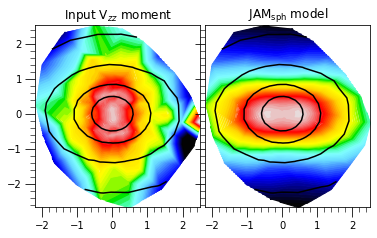

####################################################
####################################################
Modeling moment z
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 3.45
inc=80.0; beta[0]=0.20; kappa=-5.31; M/L=1.00; BH=0.0; chi2/DOF=23.1
Total mass MGE (MSun): 4.830e+09


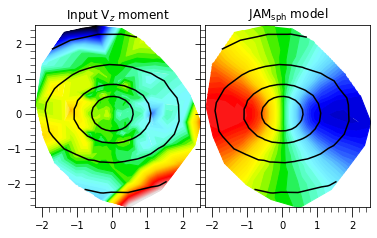

####################################################
####################################################
####################################################
Cylindrical model
####################################################
####################################################
Modeling moment zz
jam_axi_proj_cyl_zz (analytic_los=True) elapsed time sec: 0.24
inc=80.0; beta[0]=0.20; kappa=1.00; M/L=147.; BH=0.0; chi2/DOF=0.00421
Total mass MGE (MSun): 7.082e+11


<Figure size 432x288 with 0 Axes>

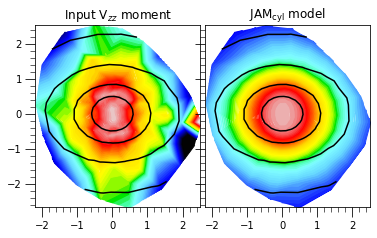

####################################################
####################################################
Modeling moment zz
jam_axi_proj_cyl_zz (analytic_los=True) elapsed time sec: 0.24
inc=80.0; beta[0]=0.20; kappa=1.00; M/L=147.; BH=0.0; chi2/DOF=0.00421
Total mass MGE (MSun): 7.082e+11


<Figure size 432x288 with 0 Axes>

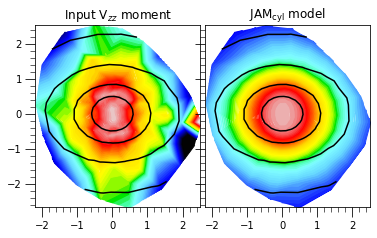

<Figure size 432x288 with 0 Axes>

In [54]:

#############################################################
# It's time to JAM now!

print('####################################################')
print('####################################################')
print('####################################################')
print(f'Spherical model')

# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

#for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):

moment = 'zz'
data = Vrms_bin
errors = dVrms_bin

print('####################################################')
print('####################################################')
print(f'Modeling moment {moment}')

inc_rad = np.radians(inc)
qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
if np.any(qintr_lum <= 0):
    print('This inclination does not work')

# The model is by design similar but not identical to the adopted kinematics!
m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                 inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='sph', ml=None, nodots=True)

plt.pause(3)
plt.figure(2)
#surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
reduced_chi_squared = m.chi2

ml = m.ml
#surf_pot = surf_pot*ml

moment = 'z'
data = V_bin
errors = dV_bin

print('####################################################')
print('####################################################')
print(f'Modeling moment {moment}')

inc_rad = np.radians(inc)
qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
if np.any(qintr_lum <= 0):
    print('This inclination does not work')

# The model is by design similar but not identical to the adopted kinematics!
m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                 inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='sph', ml=ml, nodots=True)
plt.pause(3)
plt.figure(2)
#surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
reduced_chi_squared = m.chi2

#surf_pot = surf_pot*ml


print('####################################################')
print('####################################################')
print('####################################################')
print(f'Cylindrical model')

# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

#for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):

moment = 'zz'
data = Vrms_bin
errors = dVrms_bin

print('####################################################')
print('####################################################')
print(f'Modeling moment {moment}')

inc_rad = np.radians(inc)
qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
if np.any(qintr_lum <= 0):
    print('This inclination does not work')

# The model is by design similar but not identical to the adopted kinematics!
m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                 inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='cyl', ml=None, nodots=True)

plt.pause(3)
plt.figure(2)
#surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
reduced_chi_squared = m.chi2

ml = m.ml
#surf_pot = surf_pot*ml

moment = 'z'
data = V_bin
errors = dV_bin

print('####################################################')# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

#for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):

moment = 'zz'
data = Vrms_bin
errors = dVrms_bin

print('####################################################')
print(f'Modeling moment {moment}')

inc_rad = np.radians(inc)
qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
if np.any(qintr_lum <= 0):
    print('This inclination does not work')

# The model is by design similar but not identical to the adopted kinematics!
m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                 inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='cyl', ml=ml, nodots=True)
plt.pause(3)
plt.figure(2)
#surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
reduced_chi_squared = m.chi2

#surf_pot = surf_pot*ml




________________________________________

# Define a function to prepare inputs and another to dynamically model given inputs



In [37]:
def prepare_to_jam(obj_name, file_dir, SN):

    # take the surface density, etc from mge saved parameters
    with open(f'{file_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'rb') as f:
        tommy_pickles = pickle.load(f)

    surf = tommy_pickles.surf_density
    sigma = tommy_pickles.mge_sigma
    qObs = tommy_pickles.q
    kcwi_sigmapsf = tommy_pickles.kcwi_sigmapsf
    Vrms_bin = tommy_pickles.Vrms_bin
    dVrms_bin = tommy_pickles.dVrms_bind # mistake in name
    V_bin = tommy_pickles.V_bin
    dV_bin = tommy_pickles.dV_bin
    xbin_phot = tommy_pickles.xbin_phot
    ybin_phot = tommy_pickles.ybin_phot
    reff = tommy_pickles.reff
    
    return (surf, sigma, qObs, kcwi_sigmapsf, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff)




In [35]:

def its_time_to_jam_now(obj_name, surf, sigma, qObs, kcwi_sigmapsf, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff, distance):
    #############################################################
    # It's time to JAM now!
    
    # model-dependent and free parameters
    '''
    Inclination
    '''
    inc = 80          # Assumed galaxy inclination (free parameter?)
    '''
    Anisotropy - beta for each gaussian k
    '''
    # constant beta - Do opsikov-merritt later
    beta = np.full_like(surf, 0.2)
    '''
    What do I do for black hole mass? - According to CF, he thinks it probably doesn't matter
    '''
    mbh = 0# 1e8 # Black hole mass in solar masses # not sure what to do here
    
    # Below I assume mass follows light, but in a real application one
    # will generally include a dark halo in surf_pot, sigma_pot, qobs_pot.
    # See e.g. Cappellari (2013) for an example
    # https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C
    surf_lum = surf_pot = surf
    sigma_lum = sigma_pot = sigma
    qobs_lum = qobs_pot = qObs

    print('####################################################')
    print('####################################################')
    print('####################################################')
    print(f'Spherical model')

    # I use a loop below, just to higlight the fact that all parameters# model-dependent and free parameters

    '''
    Inclination
    '''
    inc = 80          # Assumed galaxy inclination (free parameter?)
    '''
    Anisotropy - beta for each gaussian k
    '''
    # constant beta - Do opsikov-merritt later
    beta = np.full_like(surf, 0.2)
    
    '''
    What do I do for black hole mass? - According to CF, he thinks it probably doesn't matter
    '''
    mbh = 0# 1e8 # Black hole mass in solar masses # not sure what to do here
    
    # Below I assume mass follows light, but in a real application one
    # will generally include a dark halo in surf_pot, sigma_pot, qobs_pot.
    # See e.g. Cappellari (2013) for an example
    # https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C
    surf_lum = surf_pot = surf
    sigma_lum = sigma_pot = sigma
    qobs_lum = qobs_pot = qObs
    # remain the same for the two JAM calls, except for 'moment' and 'data'
    plt.figure(1)

    #for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):

    moment = 'zz'
    data = Vrms_bin
    errors = dVrms_bin

    print('####################################################')
    print('####################################################')
    print(f'Modeling moment {moment}')

    inc_rad = np.radians(inc)
    qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
    if np.any(qintr_lum <= 0):
        print('This inclination does not work')

    # The model is by design similar but not identical to the adopted kinematics!
    m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                     inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                     sigmapsf=sigmapsf, #normpsf=normpsf,
                     #flux_obs=flux_obs,
                     beta=beta, pixsize=pixsize,
                     moment=moment, goodbins=goodbins, 
                     align='sph', ml=None, nodots=True)

    plt.pause(3)
    plt.figure(2)
    #surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
    reduced_chi_squared = m.chi2

    ml = m.ml
    #surf_pot = surf_pot*ml

    moment = 'z'
    data = V_bin
    errors = dV_bin

    print('####################################################')
    print('####################################################')
    print(f'Modeling moment {moment}')

    inc_rad = np.radians(inc)
    qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
    if np.any(qintr_lum <= 0):
        print('This inclination does not work')

    # The model is by design similar but not identical to the adopted kinematics!
    m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                     inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                     sigmapsf=sigmapsf, #normpsf=normpsf,
                     #flux_obs=flux_obs,
                     beta=beta, pixsize=pixsize,
                     moment=moment, goodbins=goodbins, 
                     align='sph', ml=ml, nodots=True)
    plt.pause(3)
    plt.figure(2)
    #surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
    reduced_chi_squared = m.chi2

    #surf_pot = surf_pot*ml
    


    print('####################################################')
    print('####################################################')
    print('####################################################')
    print(f'Cylindrical model')

    # I use a loop below, just to higlight the fact that all parameters
    # remain the same for the two JAM calls, except for 'moment' and 'data'
    plt.figure(1)

    #for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):

    moment = 'zz'
    data = Vrms_bin
    errors = dVrms_bin

    print('####################################################')
    print('####################################################')
    print(f'Modeling moment {moment}')

    inc_rad = np.radians(inc)
    qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
    if np.any(qintr_lum <= 0):
        print('This inclination does not work')

    # The model is by design similar but not identical to the adopted kinematics!
    m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                     inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                     sigmapsf=sigmapsf, #normpsf=normpsf,
                     #flux_obs=flux_obs,
                     beta=beta, pixsize=pixsize,
                     moment=moment, goodbins=goodbins, 
                     align='cyl', ml=None, nodots=True)

    plt.pause(3)
    plt.figure(2)
    #surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
    reduced_chi_squared = m.chi2

    ml = m.ml
    #surf_pot = surf_pot*ml

    moment = 'z'
    data = V_bin
    errors = dV_bin

    print('####################################################')# I use a loop below, just to higlight the fact that all parameters
    # remain the same for the two JAM calls, except for 'moment' and 'data'
    plt.figure(1)

    print('####################################################')
    print(f'Modeling moment {moment}')

    inc_rad = np.radians(inc)
    qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
    if np.any(qintr_lum <= 0):
        print('This inclination does not work')

    # The model is by design similar but not identical to the adopted kinematics!
    m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                     inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                     sigmapsf=sigmapsf, #normpsf=normpsf,
                     #flux_obs=flux_obs,
                     beta=beta, pixsize=pixsize,
                     moment=moment, goodbins=goodbins, 
                     align='cyl', ml=ml, nodots=True)
    plt.pause(3)
    plt.figure(2)
    #surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
    reduced_chi_squared = m.chi2

    #surf_pot = surf_pot*ml
    



####################################################
####################################################
####################################################
Spherical model
####################################################
####################################################
Modeling moment zz
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 3.45
inc=80.0; beta[0]=0.20; kappa=1.00; M/L=151.; BH=0.0; chi2/DOF=0.00813
Total mass MGE (MSun): 7.274e+11


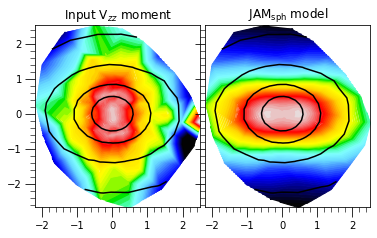

####################################################
####################################################
Modeling moment z
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 3.43
inc=80.0; beta[0]=0.20; kappa=-5.31; M/L=1.00; BH=0.0; chi2/DOF=23.1
Total mass MGE (MSun): 4.830e+09


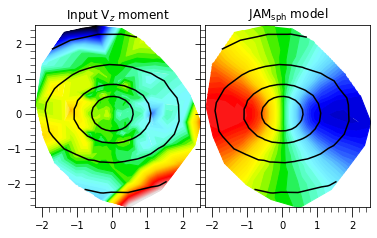

####################################################
####################################################
####################################################
Cylindrical model
####################################################
####################################################
Modeling moment zz
jam_axi_proj_cyl_zz (analytic_los=True) elapsed time sec: 0.24
inc=80.0; beta[0]=0.20; kappa=1.00; M/L=147.; BH=0.0; chi2/DOF=0.00421
Total mass MGE (MSun): 7.082e+11


<Figure size 432x288 with 0 Axes>

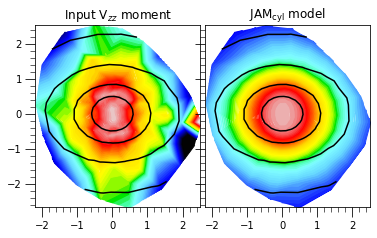

####################################################
####################################################
Modeling moment z
jam_axi_proj_cyl_z (analytic_los=False) elapsed time sec: 0.66
inc=80.0; beta[0]=0.20; kappa=-8.13; M/L=1.00; BH=0.0; chi2/DOF=23.0
Total mass MGE (MSun): 4.830e+09


<Figure size 432x288 with 0 Axes>

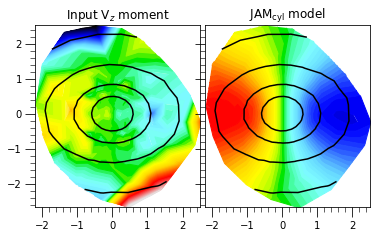

<Figure size 432x288 with 0 Axes>

In [56]:
# try with random obj_name

i = 1

obj_name = obj_names[i]
obj_abbr = obj_name[4:9] # e.g. J0029
zlens = zs[i]
distance = cosmo.angular_diameter_distance(zlens).value

mos_dir = f'{mosaics_dir}{obj_name}/' # directory with all files of obj_name
kin_dir = f'{kinematics_dir}{obj_name}/'
jam_dir = f'{jam_output_dir}{obj_name}/'
# create a directory for JAM outputs
Path(jam_dir).mkdir(parents=True, exist_ok=True)

# start with target sn of 15
SN = '15'
target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
target_jam_dir = f'{jam_dir}target_sn_{SN}/'
# create a directory for JAM outputs
Path(target_jam_dir).mkdir(parents=True, exist_ok=True)

# prepare inputs
surf, sigma, qObs, kcwi_sigmapsf, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin, ybin, reff = prepare_to_jam(obj_name, target_kin_dir, SN)
# jam now!
its_time_to_jam_now(obj_name, surf, sigma, qObs, kcwi_sigmapsf, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin, ybin, reff, distance)


__________

# Bayesian fitting with AdaMet

## Start with constant anisotropy and NFW profile


In [66]:
#############################################################
# JAM Parameters

##############################################################################

# effective radius
#reff = half_light_radius
#rbreak = 5*reff

# get the redshift

# set model to nfw
model = 'nfw'
pixsize = kcwi_scale
normpsf = 1.

##############################################################################

qmin = np.min(qObs)

# Starting guess, e.g. from a previous least-squares fit
#gamma0 = -2.0             # inner power law slope
q0 = qmin               # Axial ratio of the flattest MGE Gaussian
ratio0 = 0.8            # Anisotropy ratio sigma_z/sigma_R
f_dm0 = 0.15           # Dark matter fraction inside a sphere of radius Re
lg_ml0 = np.log10(8)  # M/L from the first fit... I sample the M/L logarithmically

# I adjusted the fitting range below after an initial fit which
# gave me an idea of some suitable ranges for the parameters
#p0 = [gamma0, q0, ratio0, f_dm0, lg_ml0]
#bounds = [[-3, 0.051, 0.5, 0, lg_ml0-0.2], [-1, qmin, 1, 0.5, lg_ml0+0.2]]
#labels = [r'$\gamma$',r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$f_{\rm DM}$", r"$\lg(M_\ast/L)$"]
p0 = [q0, ratio0, f_dm0, lg_ml0]
bounds = [[0.051, 0.5, 0, lg_ml0-0.2], [qmin, 1, 0.5, lg_ml0+0.2]]
labels = [r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$f_{\rm DM}$", r"$\lg(M_\ast/L)$"]

goodbins = np.isfinite(xbin)  # Here I fit all bins

# These parameters are passed to JAM
kwargs = {'surf_lum': surf, 'sigma_lum': sigma, 'qobs_lum': qObs,
          'distance': distance, 'xbin': xbin, 'ybin': ybin, 'sigmapsf': kcwi_sigmapsf,
          'normpsf': normpsf, 'rms':Vrms_bin, 'erms':dVrms_bin, 'pixsize': pixsize,
          'goodbins': goodbins, 'plot': 0, 'model':model, 'reff':reff}


# Check starting parameters

/home/shawnknabel/.local/lib/python3.7/site-packages/jampy/jam_axi_proj.py:869: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.clf()


-46.38863947216292

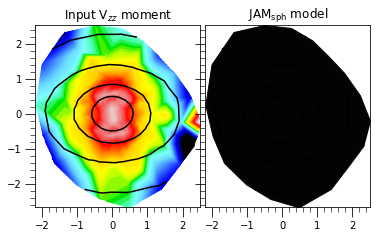

In [68]:
# I adjusted the fitting range below after an initial fit which
# gave me an idea of some suitable ranges for the parameters


jam_lnprob_nfw_constbeta(p0, surf, sigma, qObs, distance,
                          xbin, ybin, kcwi_sigmapsf, normpsf, goodbins,
                           Vrms_bin, dVrms_bin, pixsize, reff, plot=True, align='sph', model='nfw')

# Run the model...

In [71]:
#############################################################
# JAM Parameters

##############################################################################

# set mass model, anisotropy, and alignment
model = 'nfw'
anisotropy = 'const'
align = 'sph'

##############################################################################

# Starting guess, e.g. from a previous least-squares fit
#gamma0 = -2.0             # inner power law slope
q0 = qmin               # Axial ratio of the flattest MGE Gaussian
ratio0 = 0.8            # Anisotropy ratio sigma_z/sigma_R
f_dm0 = 0.15           # Dark matter fraction inside a sphere of radius Re
lg_ml0 = np.log10(ml)  # M/L from the first fit... I sample the M/L logarithmically

p0 = [q0, ratio0, f_dm0, lg_ml0]
#bounds = [[-3, 0.051, 0.5, 0, lg_ml0-0.2], [-1, qmin, 1, 0.5, lg_ml0+0.2]]
bounds = [[0.051, 0.5, 0, lg_ml0-0.2], [qmin, 1, 0.5, lg_ml0+0.2]]
#labels = [r'$\gamma$',r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$f_{\rm DM}$", r"$\lg(M_\ast/L)$"]
labels = [r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$f_{\rm DM}$", r"$\lg(M_\ast/L)$"]

goodbins = np.isfinite(xbin)  # Here I fit all bins

# These parameters are passed to JAM
kwargs = {'surf_lum': surf, 'sigma_lum': sigma, 'qobs_lum': qObs,
          'distance': distance, 'xbin': xbin, 'ybin': ybin, 'sigmapsf': kcwi_sigmapsf,
          'normpsf': normpsf, 'rms':Vrms_bin, 'erms':dVrms_bin, 'pixsize': pixsize,
          'goodbins': goodbins, 'plot': False, 'reff':reff, 
          'model':model, 'anisotropy':anisotropy, 'align':align}

# This is a rather small number of steps for illustration.
# But the distribution has already qualitatively converged
nstep = 100
sigpar = np.array([0.15, 0.15, 0.15, 0.15])  # crude estimate of uncertainties

Started AdaMet please wait...
Progress is printed periodically


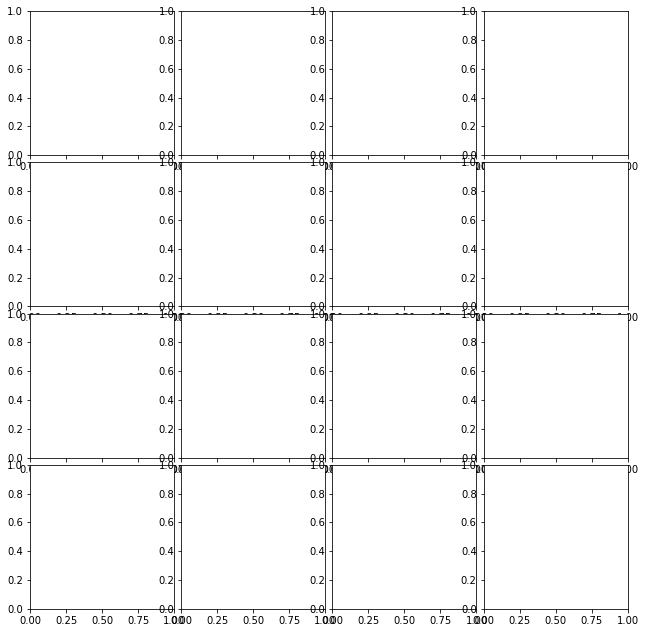

adamet: 5.0 % done; 60.0 % accepted
adamet: 10.0 % done; 40.0 % accepted
adamet: 15.0 % done; 46.7 % accepted
adamet: 20.0 % done; 40.0 % accepted
adamet: 25.0 % done; 36.0 % accepted
adamet: 30.0 % done; 30.0 % accepted
adamet: 35.0 % done; 28.6 % accepted
adamet: 40.0 % done; 32.5 % accepted
adamet: 45.0 % done; 33.3 % accepted
adamet: 50.0 % done; 36.0 % accepted
adamet: 55.0 % done; 38.2 % accepted
adamet: 60.0 % done; 38.3 % accepted
adamet: 65.0 % done; 36.9 % accepted
adamet: 70.0 % done; 38.6 % accepted
adamet: 75.0 % done; 38.7 % accepted
adamet: 80.0 % done; 41.2 % accepted
adamet: 85.0 % done; 38.8 % accepted
adamet: 90.0 % done; 37.8 % accepted
adamet: 95.0 % done; 37.9 % accepted
adamet: 100.0 % done; 38.0 % accepted
adamet: done. Total time 333.15 seconds


TypeError: summary_plot() got multiple values for argument 'save'

In [73]:
# Create directory
date_time = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
file_dir = f'{data_dir}jam_testing/'
if not os.path.exists(file_dir):
    os.mkdir(file_dir, exists='okay')
model_dir = f'{file_dir}{obj_name}_model_{date_time}_{model}_{anisotropy}/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

# Do the fit
print("Started AdaMet please wait...")
print("Progress is printed periodically")
jam_prob_func = jam_lnprob_nfw_constbeta

pars, lnprob = adamet(jam_prob_func, p0, sigpar, bounds, nstep, fignum=1,
                      kwargs=kwargs, nprint=nstep/20, labels=labels, seed=2)

# plot the results, get rms_model and flux_model of best fit
surf_potential, rms_model, flux_model, bestfit, perc, sig_bestfit = summary_plot(obj_name, date_time, model_dir, jam_prob_func, 
                                                     pars=pars, lnprob=lnprob, labels=labels, bounds=bounds, 
                                                     kwargs=kwargs, save=False, load=False)

# save parameters from fit
save_fit_parameters(model_dir, obj_name, date_time, pars, lnprob, p0, sigpar, 
                    bounds, labels, surf_potential, rms_model, flux_model, kwargs)


Best-fitting parameters and 1sigma errors:
   $q_{\rm min}$ = 0.3830 +/- 0.13
   $\sigma_z/\sigma_R$ = 0.6083 +/- 0.16
   $f_{\rm DM}$ = 0.3648 +/- 0.11
   $\lg(M_\ast/L)$ = 1.982 +/- 0.12


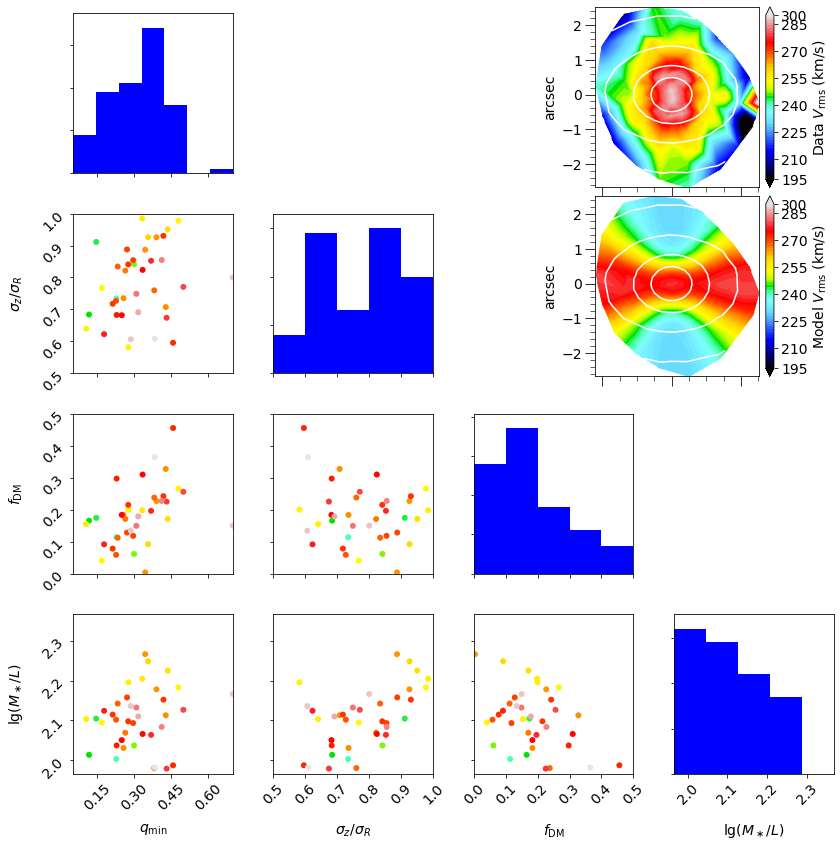

In [78]:
# plot the results, get rms_model and flux_model of best fit
surf_potential, rms_model, flux_model, bestfit, perc, sig_bestfit = summary_plot(obj_name, date_time, model_dir, jam_prob_func, 
                                                     pars=pars, lnprob=lnprob, labels=labels, bounds=bounds, 
                                                     kwargs=kwargs, save=False, load=False)

# Work on the power law

In [84]:
# Sample inclination using min(q), with Equation (14) of Cappellari (2008)
qmin = np.min(qObs)

inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q0**2)))
beta = np.full_like(qObs, 1 - ratio0**2)   # assume constant anisotropy

gamma0 = -2.0

(array([56927.93711955, 30391.11550328,  8197.48047057,  2249.94690204,
         1134.04813341,   245.95727517,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ]),
 array([1.90000000e-02, 1.65256360e-01, 4.38562052e-01, 8.93012460e-01,
        1.72185110e+00, 4.94193347e+00, 7.07106781e-03, 1.47602415e-02,
        2.96949737e-02, 5.90253039e-02, 1.16652765e-01, 2.29164883e-01,
        4.46289066e-01, 8.57135350e-01, 1.61158164e+00, 2.94660486e+00,
        5.23394257e+00, 9.09173675e+00, 1.56812628e+01, 2.80760031e+01,
        6.21918358e+01]),
 array([0.7, 0.7, 0.7, 0.7, 0.7, 0.8, 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
        1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ]))

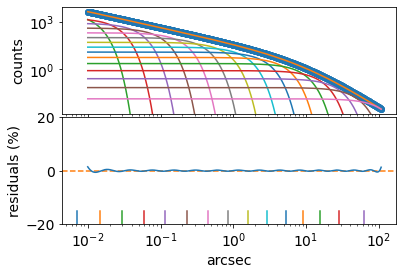

In [85]:
total_mass_mge(surf, sigma, qObs, reff, gamma0, 0, inc, lg_ml0, model, plot=True)

In [88]:
qobs = qObs
Vrms = Vrms_bin
dVrms = dVrms_bin

In [89]:
#############################################################
# JAM Parameters

##############################################################################

# set mass model, anisotropy, and alignment
model = 'power_law'
anisotropy = 'const'
align = 'sph'

##############################################################################

# Starting guess, e.g. from a previous least-squares fit
gamma0 = -2.0             # inner power law slope
q0 = qmin               # Axial ratio of the flattest MGE Gaussian
ratio0 = 0.8            # Anisotropy ratio sigma_z/sigma_R
#f_dm0 = 0.15           # Dark matter fraction inside a sphere of radius Re
lg_ml0 = 0.8# np.log10(5)  # M/L from the first fit... I sample the M/L logarithmically

p0 = [gamma0, q0, ratio0, lg_ml0]
bounds = [[-3, 0.051, 0.5, lg_ml0-0.2], [-1, qmin, 1, lg_ml0+0.2]]
#ounds = [[0.051, 0.5, 0, lg_ml0-0.2], [qmin, 1, 0.5, lg_ml0+0.2]]
#labels = [r'$\gamma$',r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$f_{\rm DM}$", r"$\lg(M_\ast/L)$"]
labels = [r'$\gamma$', r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$\lg(M_\ast/L)$"]

goodbins = np.isfinite(xbin)  # Here I fit all bins

# These parameters are passed to JAM
kwargs = {'surf_lum': surf, 'sigma_lum': sigma, 'qobs_lum': qobs,
          'distance': distance, 'xbin': xbin, 'ybin': ybin, 'sigmapsf': kcwi_sigmapsf,
          'normpsf': normpsf, 'rms':Vrms, 'erms':dVrms, 'pixsize': pixsize,
          'goodbins': goodbins, 'plot': False, 'reff':reff, 
          'model':model, 'anisotropy':anisotropy, 'align':align}

# This is a rather small number of steps for illustration.
# But the distribution has already qualitatively converged
nstep = 100
sigpar = np.array([0.15, 0.15, 0.15, 0.15])  # crude estimate of uncertainties

Started AdaMet please wait...
Progress is printed periodically


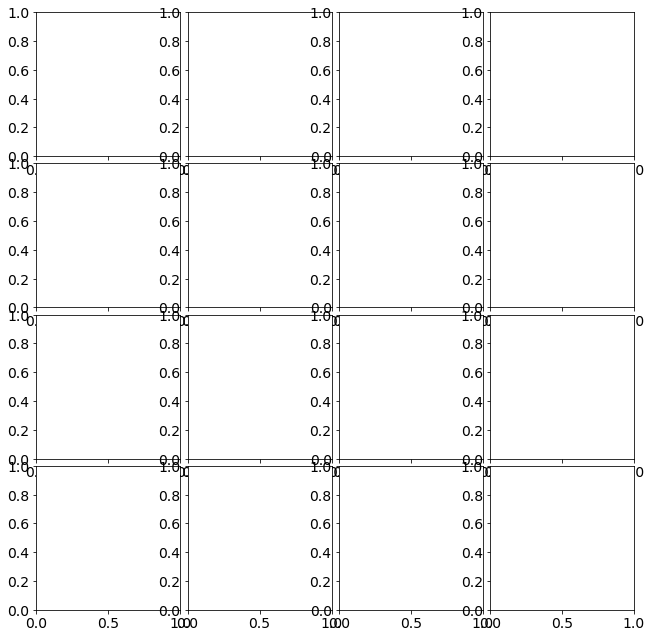

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
adamet: 5.0 % done; 40.0 % accepted
adamet: 10.0 % done; 40.0 % accepted
adamet: 15.0 % done; 26.7 % accepted
adamet: 20.0 % done; 20.0 % accepted
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
adamet: 25.0 % done; 16.0 % accepted
adamet: 30.0 % done; 13.3 % accepted
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
adamet: 35.0 % done; 11.4 % accepted
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
adamet: 40.0 % done; 15.0 % accepted
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
adamet: 45.0 % done; 15.6 % accepted
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or in

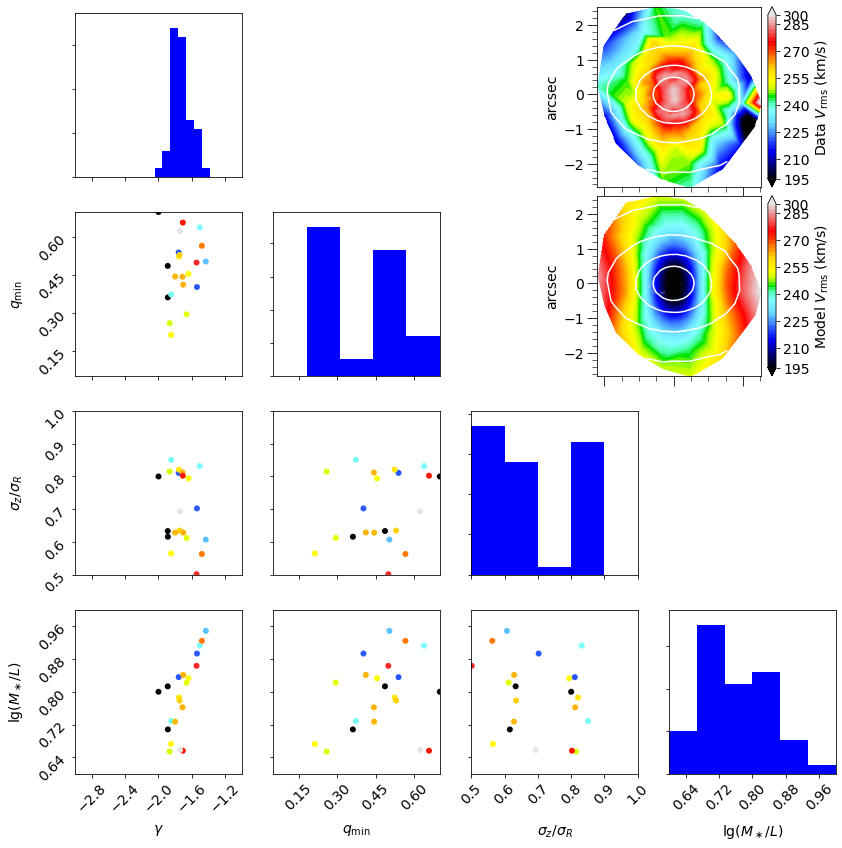

Dynamical mass estimate: 2.20e+10 +/- 5.83e+09


NameError: name 'percentiles' is not defined

In [90]:
# Create directory
date_time = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
file_dir = f'{data_dir}jam_testing/'
if not os.path.exists(file_dir):
    os.mkdir(file_dir, exists='okay')
model_dir = f'{file_dir}{obj_name}_model_{date_time}_{model}_{anisotropy}/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

# Do the fit
print("Started AdaMet please wait...")
print("Progress is printed periodically")
jam_prob_func = jam_lnprob_power_law

pars, lnprob = adamet(jam_prob_func, p0, sigpar, bounds, nstep, fignum=1,
                      kwargs=kwargs, nprint=nstep/20, labels=labels, seed=2)

# plot the results, get rms_model and flux_model of best fit
surf_potential, rms_model, flux_model, bestfit, perc, sig_bestfit = summary_plot(obj_name, date_time, model_dir, jam_prob_func, 
                                                     pars=pars, lnprob=lnprob, labels=labels, bounds=bounds, 
                                                     kwargs=kwargs, save=False, load=False)

# calculate mass estimate
# mass to light ratio
ml_ratio = bestfit[3]
dml = sig_bestfit[3]
# get the total luminosity
_, _, _, lum_tot = mge_half_light_isophote(surf, sigma, qobs, distance)
# multiply by the mass to light ratio
total_mass = 10**ml_ratio * lum_tot
total_mass_err = 10**dml * lum_tot
total_mass_sci_not = "{:.2e}".format(total_mass)
total_mass_err_sci_not = "{:.2e}".format(total_mass_err)
print(f'Dynamical mass estimate: {total_mass_sci_not} +/- {total_mass_err_sci_not}')

# save parameters from fit
save_fit_parameters(model_dir, obj_name, date_time, bestfit, sig_bestfit, percentiles, pars, lnprob, p0, sigpar, 
                    bounds, labels, surf_potential, rms_model, flux_model, kwargs)


Best-fitting parameters and 1sigma errors:
   $\gamma$ = -1.741 +/- 0.093
   $q_{\rm min}$ = 0.6239 +/- 0.17
   $\sigma_z/\sigma_R$ = 0.6932 +/- 0.12
   $\lg(M_\ast/L)$ = 0.6581 +/- 0.082
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


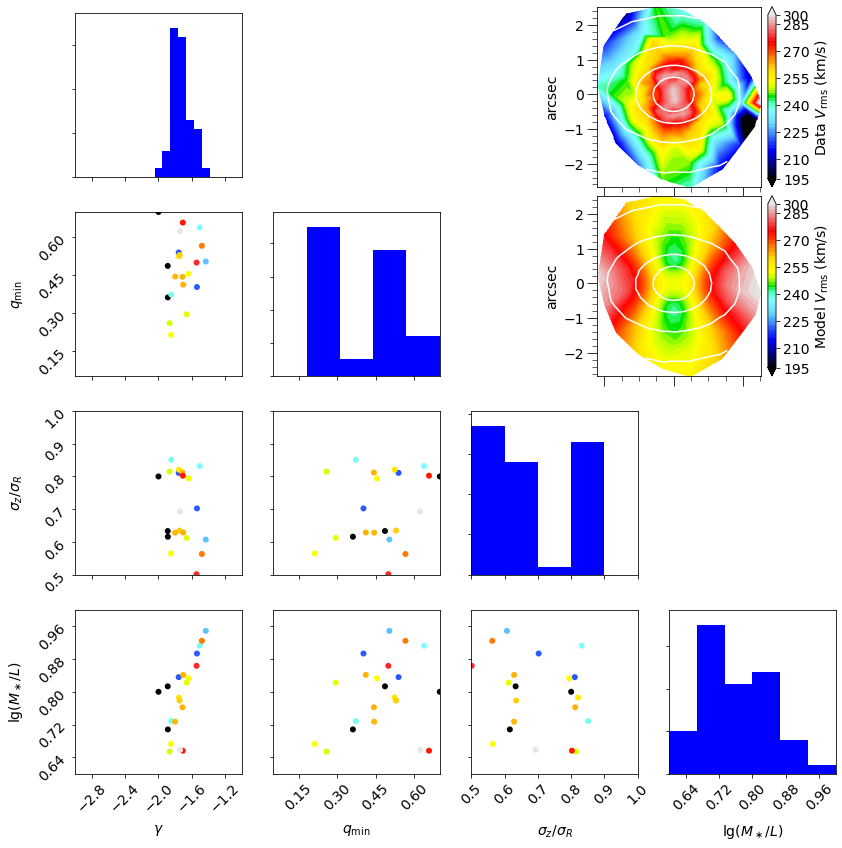

Dynamical mass estimate: 2.20e+10 +/- 5.83e+09


In [91]:
# plot the results, get rms_model and flux_model of best fit
surf_potential, rms_model, flux_model, bestfit, percentiles, sig_bestfit = summary_plot(obj_name, date_time, model_dir, jam_prob_func, 
                                                     pars=pars, lnprob=lnprob, labels=labels, bounds=bounds, 
                                                     kwargs=kwargs, save=False, load=False)


# calculate mass estimate
# mass to light ratio
ml_ratio = bestfit[3]
dml = sig_bestfit[3]
# get the total luminosity
_, _, _, lum_tot = mge_half_light_isophote(surf, sigma, qobs, distance)
# multiply by the mass to light ratio
total_mass = 10**ml_ratio * lum_tot
total_mass_err = 10**dml * lum_tot
total_mass_sci_not = "{:.2e}".format(total_mass)
total_mass_err_sci_not = "{:.2e}".format(total_mass_err)
print(f'Dynamical mass estimate: {total_mass_sci_not} +/- {total_mass_err_sci_not}')

# save parameters from fit
save_fit_parameters(model_dir, obj_name, date_time, bestfit, sig_bestfit, percentiles, pars, lnprob, p0, sigpar, 
                    bounds, labels, surf_potential, rms_model, flux_model, kwargs)

# Write a script that automates this whole thing.

In [94]:
def space_jam (obj_name, model, anisotropy, align, nstep):
    
    '''
    obj_name and number steps to try it out. Start all with the same priors.
    '''

    obj_abbr = obj_name[4:9] # e.g. J0029
    zlens = zs[i]
    distance = cosmo.angular_diameter_distance(zlens).value

    mos_dir = f'{mosaics_dir}{obj_name}/' # directory with all files of obj_name
    kin_dir = f'{kinematics_dir}{obj_name}/'
    jam_dir = f'{jam_output_dir}{obj_name}/'
    # create a directory for JAM outputs
    Path(jam_dir).mkdir(parents=True, exist_ok=True)

    # start with target sn of 15
    SN = '15'
    target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
    target_jam_dir = f'{jam_dir}target_sn_{SN}/'
    # create a directory for JAM outputs
    Path(target_jam_dir).mkdir(parents=True, exist_ok=True)

    # prepare inputs
    surf, sigma, qobs, kcwi_sigmapsf, Vrms, dVrms, V, dV, xbin, ybin, reff = prepare_to_jam(obj_name, target_kin_dir, SN)

    # get distance from z
    slacs_data = np.genfromtxt(f'{tables_dir}slacs_tableA1.txt', delimiter='', dtype='U10')
    zlens_column = slacs_data[:,3].astype(float)
    slacs_table_name = obj_name[4:]
    zlens = zlens_column[slacs_data[:,0]==slacs_table_name]
    distance = cosmo.angular_diameter_distance(zlens).value
    
    #############################################################
    # JAM Parameters
    ##############################################################################
    ##############################################################################

    # Starting guess, e.g. from a previous least-squares fit
    gamma0 = -2.0             # inner power law slope
    q0 = np.median(qobs)         # Axial ratio ... why did I have that -> # q0 = np.min(qobs) Axial ratio of the flattest MGE Gaussian
    ratio0 = 0.8            # Anisotropy ratio sigma_z/sigma_R
    #f_dm0 = 0.15           # Dark matter fraction inside a sphere of radius Re
    lg_ml0 = 0.8 # np.log10(5)  # M/L from the first fit... I sample the M/L logarithmically

    p0 = [gamma0, q0, ratio0, lg_ml0]
    bounds = [[-3, 0.051, 0.5, lg_ml0-0.3], [-1, np.min(qobs), 1, lg_ml0+0.3]]
    #ounds = [[0.051, 0.5, 0, lg_ml0-0.2], [qmin, 1, 0.5, lg_ml0+0.2]]
    #labels = [r'$\gamma$',r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$f_{\rm DM}$", r"$\lg(M_\ast/L)$"]
    labels = [r'$\gamma$', r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$\lg(M_\ast/L)$"]

    goodbins = np.isfinite(xbin)  # Here I fit all bins

    # These parameters are passed to JAM
    kwargs = {'surf_lum': surf, 'sigma_lum': sigma, 'qobs_lum': qobs,
              'distance': distance, 'xbin': xbin, 'ybin': ybin, 'sigmapsf': kcwi_sigmapsf,
              'normpsf': 1., 'rms':Vrms, 'erms':dVrms, 'pixsize': kcwi_scale,
              'goodbins': goodbins, 'plot': False, 'reff':reff, 
              'model':model, 'anisotropy':anisotropy, 'align':align}

    # This is a rather small number of steps for illustration.
    # But the distribution has already qualitatively converged
    #nstep = nstep #100
    sigpar = np.array([0.15, 0.15, 0.15, 0.15])  # crude estimate of uncertainties
    
    # Create directory
    date_time = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
    jam_file_dir = f'{data_dir}jam_testing/'
    if not os.path.exists(file_dir):
        os.mkdir(jam_file_dir, exists='okay')
    model_dir = f'{jam_file_dir}{obj_name}_model_{date_time}_{model}_{anisotropy}/'
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
        
    #############################################################
    # Do the AdaMet fit
    ##############################################################################
    ##############################################################################

    # Do the fit
    print("Started AdaMet please wait...")
    print("Progress is printed periodically")
    #jam_prob_func = jam_lnprob_power_law

    pars, lnprob = adamet(jam_lnprob_power_law, p0, sigpar, bounds, nstep, fignum=1,
                          kwargs=kwargs, nprint=nstep/20, labels=labels, seed=2)

    # plot the results, get rms_model and flux_model of best fit
    surf_potential, rms_model, flux_model, bestfit, percentiles, sig_bestfit = summary_plot(xbin, ybin, goodbins, Vrms, pars, lnprob, 
                                                                                             labels, bounds, kwargs, obj_name, date_time,
                                                                                             model_dir, jam_lnprob_power_law, save=False)


    # calculate mass estimate
    # mass to light ratio
    ml_ratio = bestfit[3]
    dml = sig_bestfit[3]
    # get the total luminosity
    _, _, _, lum_tot = mge_half_light_isophote(surf, sigma, qobs, distance)
    # multiply by the mass to light ratio
    total_mass = 10**ml_ratio * lum_tot
    total_mass_err = 10**dml * lum_tot
    total_mass_sci_not = "{:.2e}".format(total_mass)
    total_mass_err_sci_not = "{:.2e}".format(total_mass_err)
    print(f'Dynamical mass estimate: {total_mass_sci_not} +/- {total_mass_err_sci_not}')

    # save parameters from fit
    save_fit_parameters(model_dir, obj_name, date_time, bestfit, sig_bestfit, percentiles, pars, lnprob, p0, sigpar, 
                        bounds, labels, surf_potential, rms_model, flux_model, kwargs)

# Run a very quick one for each object with power law, constant anisotropy, and spherical alignment.
# This function will not work for anything else.

Thank you for choosing MiseryBot 9.3.2, where you will hate everything and probably quit after a short while.
...
...
...
Please hold...
...

Ah yes, the JAM routine. This one is fun.
...
...
...
But where to start?
...
########################################################
########################################################
Jamming object SDSSJ0029-0055.
Brace for jamming.
########################################################
Started AdaMet please wait...
Progress is printed periodically


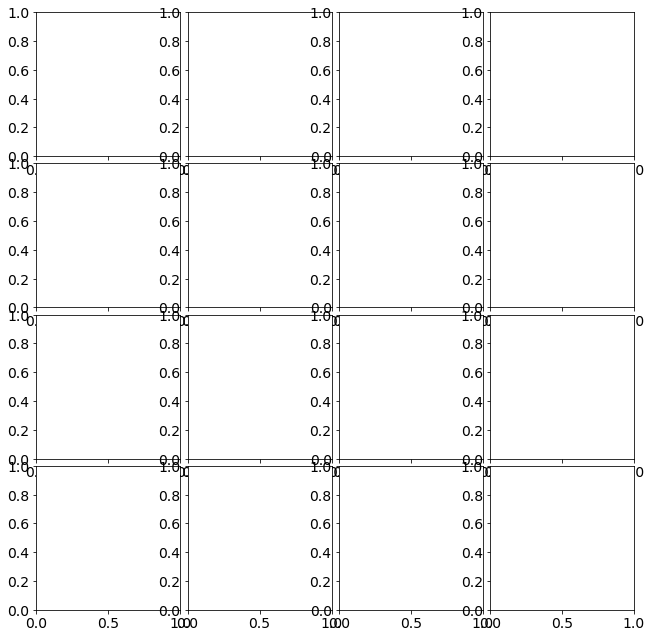

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 

TypeError: summary_plot() got multiple values for argument 'save'

In [95]:
# set mass model, anisotropy, and alignment
model = 'power_law'
anisotropy = 'const'
align = 'sph'

# set nstep
nstep=1000

print('Thank you for choosing MiseryBot 9.3.2, where you will hate everything and probably quit after a short while.')
print('...')
print('...')
print('...')
print('Please hold...')
print('...')

print('')
print('Ah yes, the JAM routine. This one is fun.')
print('...')
print('...')
print('...')
print('But where to start?')
print('...')

print('########################################################')
print('########################################################')

for i, obj_name in enumerate(obj_names[:3]):
    
    print(f'Jamming object {obj_name}.')
    print('Brace for jamming.')
    print('########################################################') 
    
    if i == 6:
        print('Object 6 is unsatisfactory.')
        continue
    else:
        space_jam(obj_name, model, anisotropy, align, nstep)
        
    print('########################################################') 
    print('Jamming complete. On to the next?')
    print('########################################################') 
    print('########################################################') 
    
print('Okay, all done. Thank you for using MiseryBot 9.1.3. We deprecated while you were away. Hope you data is not corrupted.')


# Let's make the function work for all the different variations we want.

In [114]:
def summary_plot(obj_name, date_time, model_dir, jam_prob_func, pars=None, lnprob=None, labels=None, bounds=None, kwargs=None, save=False, load=False):
    """
    Print the best fitting solution with uncertainties.
    Plot the final corner plot with the best fitting JAM model.

    """
    
    xbin = kwargs['xbin']
    ybin = kwargs['ybin']
    goodbins = kwargs['goodbins']
    rms = kwargs['rms']
    
    if load == True:
        jam_test_dir = f'{data_dir}jam_testing/2023_01_31/'
        pars = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*parameters_fit.txt')[0])
        lnprob = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*likelihood.txt')[0])
        labels = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*labels.txt')[0], delimiter='  ', dtype='<U20')
        bounds = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*bounds.txt')[0])
        bestfit = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*bestfit_parameters.txt')[0])
        perc = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*bestfit_parameters_percentile.txt')[0])
        sig_bestfit = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*bestfit_parameters_error.txt')[0])
        surf_potential = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*surf_potential.txt')[0])
        rms_model = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*rms_model.txt')[0])
        flux_model = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*flux_model.txt')[0])
    
    else:
    
        bestfit = pars[np.argmax(lnprob)]  # Best fitting parameters
        perc = np.percentile(pars, [15.86, 84.14], axis=0)  # 68% interval
        sig_bestfit = np.squeeze(np.diff(perc, axis=0)/2)   # half of interval (1sigma)
        
        # save variables, surf_pot, sigma_pot, qobs_pot, rms_model and flux_model
        surf_potential = jam_prob_func.surf_potential
        rms_model = jam_prob_func.rms_model
        flux_model = jam_prob_func.flux_model

    print("\nBest-fitting parameters and 1sigma errors:")
    for label, best, sig in zip(labels, bestfit, sig_bestfit):
        print(f"   {label} = {best:#.4g} +/- {sig:#.2g}")

    # Produce final corner plot without trial values and with best fitting JAM
    plt.rcParams.update({'font.size': 14})
    plt.clf()
    corner_plot(pars, lnprob, labels=labels, extents=bounds, fignum=1)
    chi2 = jam_prob_func(bestfit, **kwargs)  # Compute model at best fit location
     
    dx = 0.24
    yfac = 0.87
    fig = plt.gcf()
    fig.set_size_inches((12,12))
    fig.tight_layout()
    
    # plot data
    fig.add_axes([0.69, 0.99 - dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
    rms1 = rms.copy()
    rms1[goodbins] = symmetrize_velfield(xbin[goodbins], ybin[goodbins], rms[goodbins])
    vmin, vmax = np.percentile(rms1[goodbins], [0.5, 99.5])
    plot_velfield(xbin, ybin, rms1, vmin=vmin, vmax=vmax, linescolor='w', 
                  colorbar=1, label=r"Data $V_{\rm rms}$ (km/s)", flux=flux_model, nodots=True)
    plt.tick_params(labelbottom=False)
    plt.ylabel('arcsec')
    
    # plot model
    print('model: ', rms_model)
    fig.add_axes([0.69, 0.98 - 2*dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
    plot_velfield(xbin, ybin, rms_model, vmin=vmin, vmax=vmax, linescolor='w',
                  colorbar=1, label=r"Model $V_{\rm rms}$ (km/s)", flux=flux_model, nodots=True)
    plt.tick_params(labelbottom=False)
    plt.ylabel('arcsec')
    if save==True:
        plt.savefig(f'{model_dir}{obj_name}corner_plot{date_time}.png', bbox_inches='tight')
        plt.savefig(f'{model_dir}{obj_name}corner_plot{date_time}.pdf', bbox_inches='tight')

    plt.pause(1)
    plt.clf()
    plt.close()
                                                                
        
    return surf_potential, rms_model, flux_model, bestfit, perc, sig_bestfit


In [119]:
def space_jam (obj_name, SN, model, anisotropy, align, nstep, p0=None, bounds=None):
    
    '''
    obj_name and number steps to try it out. Start all with the same priors.
    '''

    obj_abbr = obj_name[4:9] # e.g. J0029
    zlens = zs[i]
    distance = cosmo.angular_diameter_distance(zlens).value

    mos_dir = f'{mosaics_dir}{obj_name}/' # directory with all files of obj_name
    kin_dir = f'{kinematics_dir}{obj_name}/'
    jam_dir = f'{jam_output_dir}{obj_name}/'
    # create a directory for JAM outputs
    Path(jam_dir).mkdir(parents=True, exist_ok=True)
    
    if obj_abbr=='J0330':
        target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
    target_jam_dir = f'{jam_dir}target_sn_{SN}/'
    # create a directory for JAM outputs
    Path(target_jam_dir).mkdir(parents=True, exist_ok=True)

    # prepare inputs
    surf, sigma, qobs, kcwi_sigmapsf, Vrms, dVrms, V, dV, xbin, ybin, reff = prepare_to_jam(obj_name, target_kin_dir, SN)

    # get distance from z
    slacs_data = np.genfromtxt(f'{tables_dir}slacs_tableA1.txt', delimiter='', dtype='U10')
    zlens_column = slacs_data[:,3].astype(float)
    slacs_table_name = obj_name[4:]
    zlens = zlens_column[slacs_data[:,0]==slacs_table_name]
    distance = cosmo.angular_diameter_distance(zlens).value
    
    #############################################################
    # JAM Parameters
    ##############################################################################
    ##############################################################################
    
    if model=='power_law':
        jam_prob_func = jam_lnprob_power_law
        if anisotropy=='const':
            if p0==None:
                # Starting guess, e.g. from a previous least-squares fit
                gamma0 = -2.0             # inner power law slope
                q0 = np.median(qobs)         # Axial ratio ... why did I have that -> # q0 = np.min(qobs) Axial ratio of the flattest MGE Gaussian
                ratio0 = 0.8            # Anisotropy ratio sigma_z/sigma_R
                #f_dm0 = 0.15           # Dark matter fraction inside a sphere of radius Re
                lg_ml0 = 0.8 # np.log10(5)  # M/L from the first fit... I sample the M/L logarithmically

                p0 = [gamma0, q0, ratio0, lg_ml0]
                bounds = [[-3, 0.051, 0.5, lg_ml0-0.3], [-1, np.min(qobs), 1, lg_ml0+0.3]]
                #ounds = [[0.051, 0.5, 0, lg_ml0-0.2], [qmin, 1, 0.5, lg_ml0+0.2]]
                #labels = [r'$\gamma$',r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$f_{\rm DM}$", r"$\lg(M_\ast/L)$"]
                sigpar = np.array([0.15, 0.15, 0.15, 0.15])  # crude estimate of uncertainties    
            labels = [r'$\gamma$', r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$\lg(M_\ast/L)$"]
        elif anisotropy=='OM':
            print('we have no OM at the moment')
    elif model=='nfw':
        jam_prob_func = jam_lnprob_nfw_constbeta
        if anisotropy=='const':
            if p0==None:
                # Starting guess, e.g. from a previous least-squares fit
                #gamma0 = -2.0             # inner power law slope
                q0 = qmin               # Axial ratio of the flattest MGE Gaussian
                ratio0 = 0.8            # Anisotropy ratio sigma_z/sigma_R
                f_dm0 = 0.15           # Dark matter fraction inside a sphere of radius Re
                lg_ml0 = np.log10(ml)  # M/L from the first fit... I sample the M/L logarithmically
                p0 = [q0, ratio0, f_dm0, lg_ml0]
                #bounds = [[-3, 0.051, 0.5, 0, lg_ml0-0.2], [-1, qmin, 1, 0.5, lg_ml0+0.2]]
                bounds = [[0.051, 0.5, 0, lg_ml0-0.2], [qmin, 1, 0.5, lg_ml0+0.2]]
                #labels = [r'$\gamma$',r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$f_{\rm DM}$", r"$\lg(M_\ast/L)$"]
                sigpar = np.array([0.15, 0.15, 0.15, 0.15])  # crude estimate of uncertainties
            labels = [r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$f_{\rm DM}$", r"$\lg(M_\ast/L)$"]
        elif anisotropy=='OM':
            print('no OM at this point')

    goodbins = np.isfinite(xbin)  # Here I fit all bins

    # These parameters are passed to JAM
    kwargs = {'surf_lum': surf, 'sigma_lum': sigma, 'qobs_lum': qobs,
              'distance': distance, 'xbin': xbin, 'ybin': ybin, 'sigmapsf': kcwi_sigmapsf,
              'normpsf': 1., 'rms':Vrms, 'erms':dVrms, 'pixsize': kcwi_scale,
              'goodbins': goodbins, 'plot': False, 'reff':reff, 
              'model':model, 'anisotropy':anisotropy, 'align':align}

    # This is a rather small number of steps for illustration.
    # But the distribution has already qualitatively converged
    #nstep = nstep #100
    
    # Create directory
    date_time = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
    jam_file_dir = f'{data_dir}jam_testing/'
    if not os.path.exists(jam_file_dir):
        os.mkdir(jam_file_dir, exists='okay')
    model_dir = f'{jam_file_dir}{obj_name}_model_{date_time}_{model}_{anisotropy}/'
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
        
    #############################################################
    # Do the AdaMet fit
    ##############################################################################
    ##############################################################################

    # Do the fit
    print("Started AdaMet please wait...")
    print("Progress is printed periodically")

    pars, lnprob = adamet(jam_prob_func, p0, sigpar, bounds, nstep, fignum=1,
                          kwargs=kwargs, nprint=nstep/20, labels=labels, seed=2)

    # plot the results, get rms_model and flux_model of best fit
    surf_potential, rms_model, flux_model, bestfit, percentiles, sig_bestfit = summary_plot(obj_name, date_time, model_dir, jam_prob_func, 
                                                                                             pars=pars, lnprob=lnprob, labels=labels, bounds=bounds, 
                                                                                             kwargs=kwargs, save=False, load=False)


    # calculate mass estimate
    # mass to light ratio
    ml_ratio = bestfit[3]
    dml = sig_bestfit[3]
    # get the total luminosity
    _, _, _, lum_tot = mge_half_light_isophote(surf, sigma, qobs, distance)
    # multiply by the mass to light ratio
    total_mass = 10**ml_ratio * lum_tot
    total_mass_err = 10**dml * lum_tot
    total_mass_sci_not = "{:.2e}".format(total_mass)
    total_mass_err_sci_not = "{:.2e}".format(total_mass_err)
    print(f'Dynamical mass estimate: {total_mass_sci_not} +/- {total_mass_err_sci_not}')

    # save parameters from fit
    save_fit_parameters(model_dir, obj_name, date_time, bestfit, sig_bestfit, percentiles, pars, lnprob, p0, sigpar, 
                        bounds, labels, surf_potential, rms_model, flux_model, kwargs)

Thank you for choosing MiseryBot 9.3.2, where you will hate everything and probably quit after a short while.
...
...
...
Please hold...
...

Ah yes, the JAM routine. This one is fun.
...
...
...
But where to start?
...
########################################################
########################################################
Jamming object SDSSJ0029-0055.
Brace for jamming.
########################################################
Designated target is S/N 15.
Commencing JAM routine with model nfw, anisotropy const, and alignment sph... number of steps 10
JAMMING.
########################################################
Started AdaMet please wait...
Progress is printed periodically


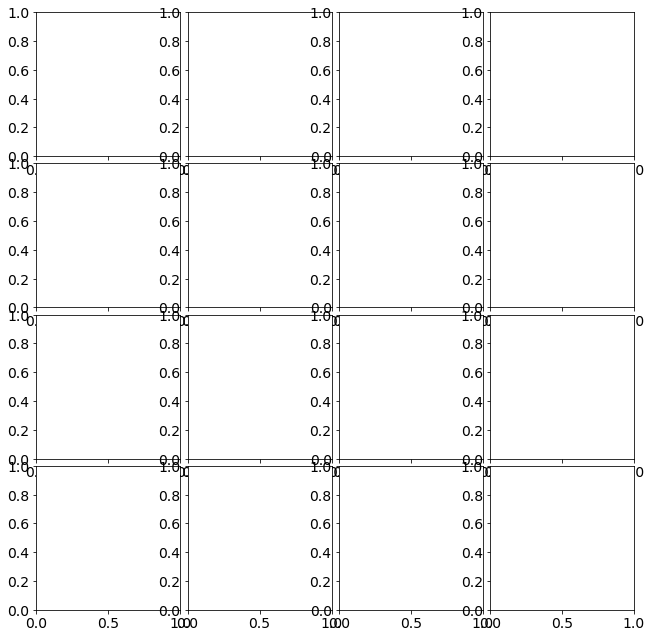

adamet: 10.0 % done; 0.0 % accepted
adamet: 20.0 % done; 50.0 % accepted
adamet: 30.0 % done; 66.7 % accepted
adamet: 40.0 % done; 50.0 % accepted
adamet: 50.0 % done; 40.0 % accepted
adamet: 60.0 % done; 33.3 % accepted
adamet: 70.0 % done; 28.6 % accepted
adamet: 80.0 % done; 25.0 % accepted
adamet: 90.0 % done; 22.2 % accepted
adamet: 100.0 % done; 20.0 % accepted
adamet: done. Total time 31.44 seconds

Best-fitting parameters and 1sigma errors:
   $q_{\rm min}$ = 0.4310 +/- 0.0
   $\sigma_z/\sigma_R$ = 0.6737 +/- 0.0
   $f_{\rm DM}$ = 0.2254 +/- 0.0
   $\lg(M_\ast/L)$ = 1.979 +/- 0.0
model:  [908.22897623 914.28394861 918.6012251  913.71546996 913.71546996
 910.39958921 914.28394861 901.27363646 910.39958921 886.33942091
 884.2953009  897.9158933  900.78859285 872.90198498 835.13206786
 885.29994234 890.4477661  781.08839091 842.44236311 799.04303202
 802.84064998 698.95600363 803.23140616 681.8598524  702.63884107
 827.97020619 848.83624981 672.20637076 725.84859746 607.79673083
 

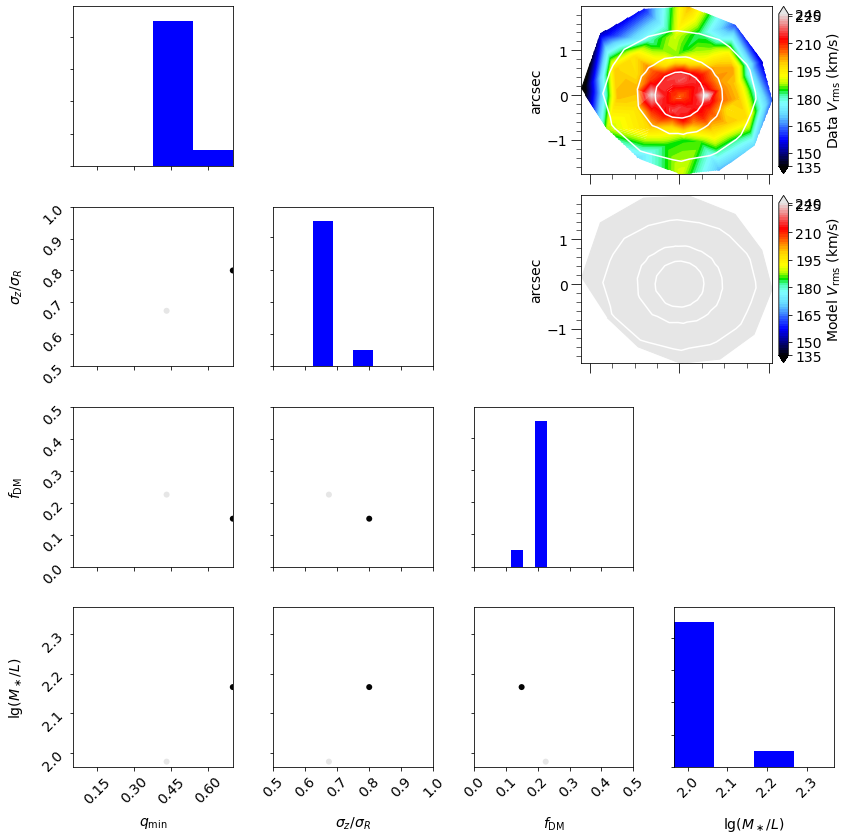

Dynamical mass estimate: 3.71e+12 +/- 3.89e+10
########################################################
We've been... JAMMED! On to the next?
########################################################
########################################################
Commencing JAM routine with model nfw, anisotropy const, and alignment cyl... number of steps 10
JAMMING.
########################################################
Started AdaMet please wait...
Progress is printed periodically


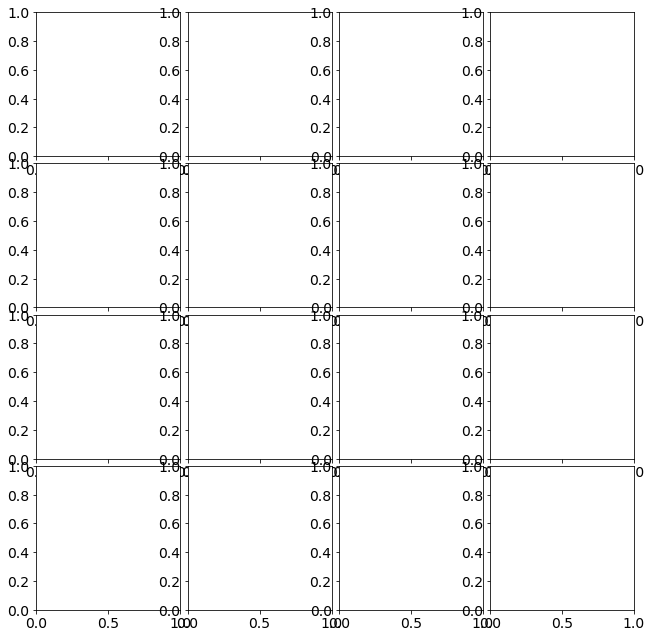

adamet: 10.0 % done; 0.0 % accepted
adamet: 20.0 % done; 50.0 % accepted
adamet: 30.0 % done; 66.7 % accepted
adamet: 40.0 % done; 50.0 % accepted
adamet: 50.0 % done; 40.0 % accepted
adamet: 60.0 % done; 33.3 % accepted
adamet: 70.0 % done; 28.6 % accepted
adamet: 80.0 % done; 25.0 % accepted
adamet: 90.0 % done; 22.2 % accepted
adamet: 100.0 % done; 20.0 % accepted
adamet: done. Total time 8.06 seconds

Best-fitting parameters and 1sigma errors:
   $q_{\rm min}$ = 0.4310 +/- 0.0
   $\sigma_z/\sigma_R$ = 0.6737 +/- 0.0
   $f_{\rm DM}$ = 0.2254 +/- 0.0
   $\lg(M_\ast/L)$ = 1.979 +/- 0.0
model:  [901.89809893 903.51377433 908.20454861 904.60655431 904.60655431
 897.79041188 903.51377433 898.19679546 897.79041188 884.67194409
 874.14999351 880.91823759 888.85510944 853.46118507 858.52533902
 886.00567279 877.45193999 821.65491142 847.77457449 824.18917255
 802.56643624 770.70052478 780.31140505 738.91555167 721.44755864
 792.11977809 816.67444449 743.80062002 740.5191026  703.68912763
 6

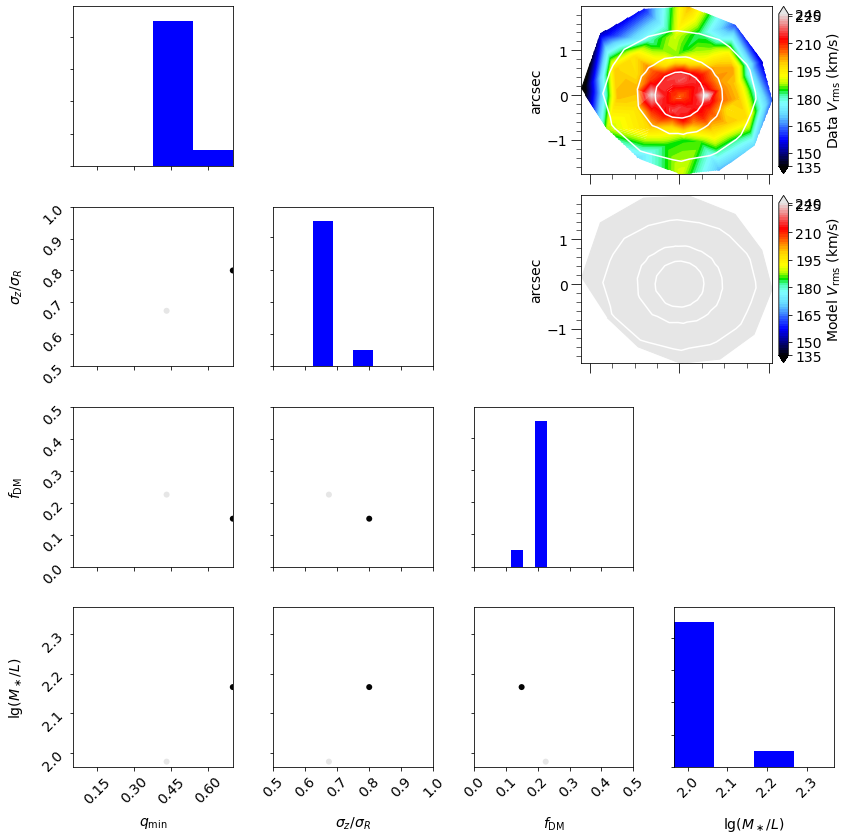

Dynamical mass estimate: 3.71e+12 +/- 3.89e+10
########################################################
We've been... JAMMED! On to the next?
########################################################
########################################################
Designated target is S/N 20.
Commencing JAM routine with model nfw, anisotropy const, and alignment sph... number of steps 10
JAMMING.
########################################################
Started AdaMet please wait...
Progress is printed periodically


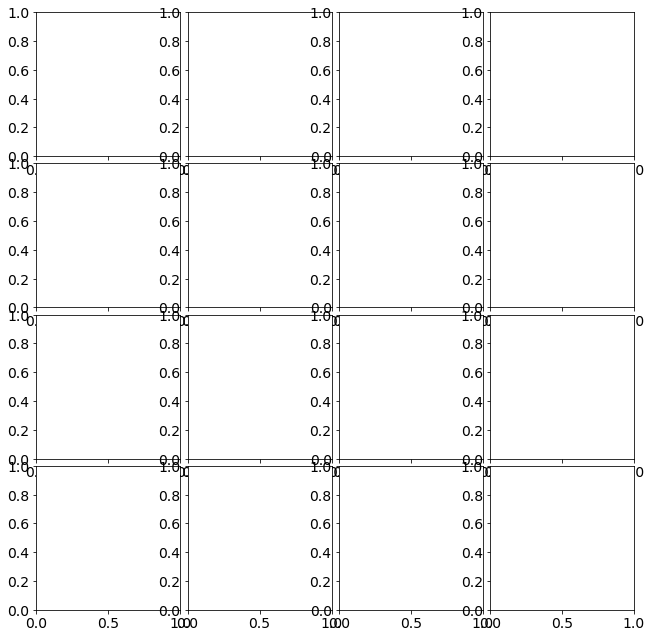

adamet: 10.0 % done; 0.0 % accepted
adamet: 20.0 % done; 50.0 % accepted
adamet: 30.0 % done; 66.7 % accepted
adamet: 40.0 % done; 50.0 % accepted
adamet: 50.0 % done; 40.0 % accepted
adamet: 60.0 % done; 33.3 % accepted
adamet: 70.0 % done; 28.6 % accepted
adamet: 80.0 % done; 25.0 % accepted
adamet: 90.0 % done; 22.2 % accepted
adamet: 100.0 % done; 20.0 % accepted
adamet: done. Total time 31.50 seconds

Best-fitting parameters and 1sigma errors:
   $q_{\rm min}$ = 0.4310 +/- 0.0
   $\sigma_z/\sigma_R$ = 0.6737 +/- 0.0
   $f_{\rm DM}$ = 0.2254 +/- 0.0
   $\lg(M_\ast/L)$ = 1.979 +/- 0.0
model:  [912.45275624 917.61396909 893.49218225 883.87588898 890.42656014
 852.69947468 881.80116369 806.63248851 804.21976174 861.99547501
 895.77451092 913.0853476  854.50111055 781.07435645 721.28502159
 691.6163945  674.21811286 790.47668572 881.23116629 688.18805221
 811.42241947 906.6735692  888.03775879 846.55660629 717.92887798
 778.13698262 858.14918384 652.40981514 596.60168197 612.62288078
 

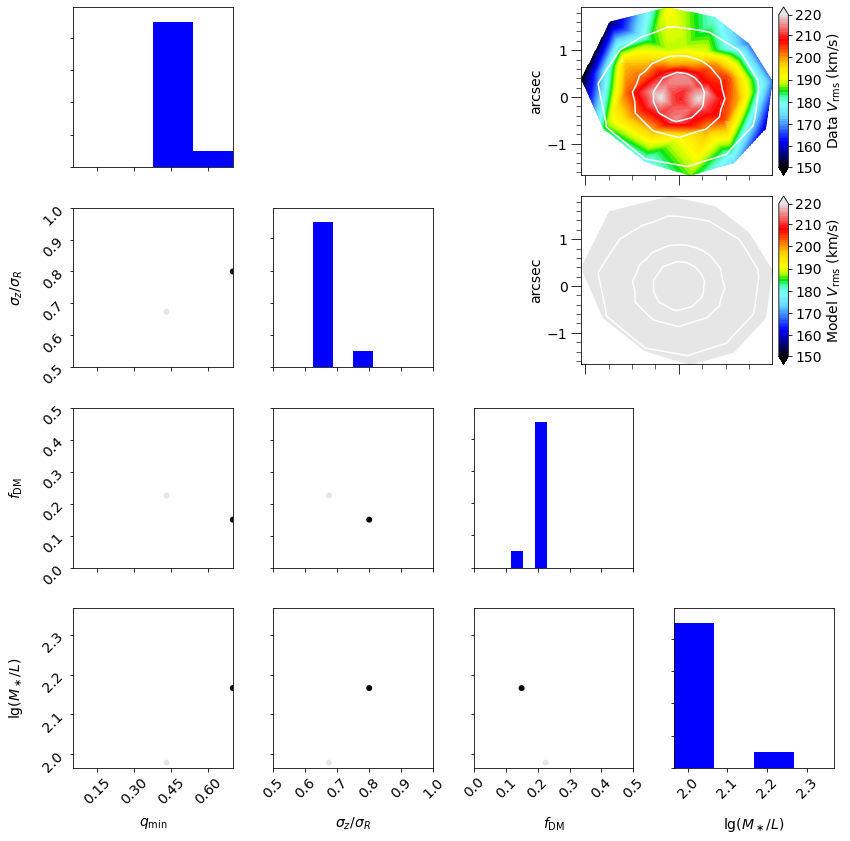

Dynamical mass estimate: 3.71e+12 +/- 3.89e+10
########################################################
We've been... JAMMED! On to the next?
########################################################
########################################################
Commencing JAM routine with model nfw, anisotropy const, and alignment cyl... number of steps 10
JAMMING.
########################################################
Started AdaMet please wait...
Progress is printed periodically


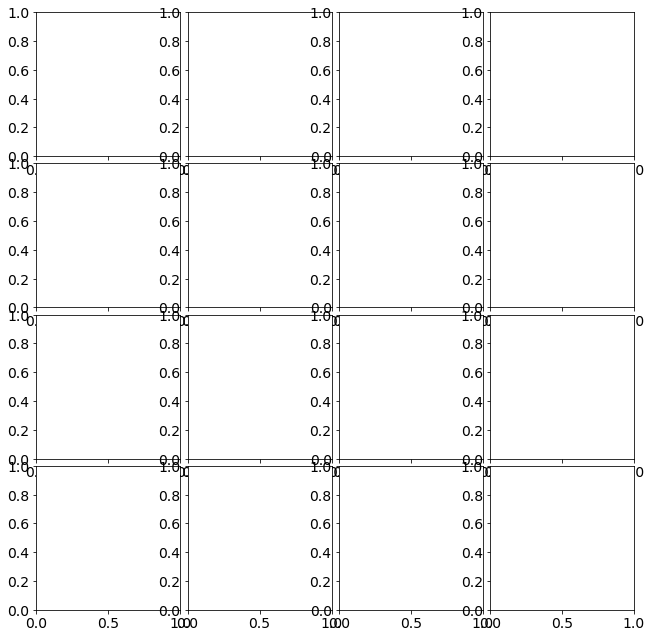

adamet: 10.0 % done; 0.0 % accepted
adamet: 20.0 % done; 50.0 % accepted
adamet: 30.0 % done; 66.7 % accepted
adamet: 40.0 % done; 50.0 % accepted
adamet: 50.0 % done; 40.0 % accepted
adamet: 60.0 % done; 33.3 % accepted
adamet: 70.0 % done; 28.6 % accepted
adamet: 80.0 % done; 25.0 % accepted
adamet: 90.0 % done; 22.2 % accepted
adamet: 100.0 % done; 20.0 % accepted
adamet: done. Total time 8.13 seconds

Best-fitting parameters and 1sigma errors:
   $q_{\rm min}$ = 0.4310 +/- 0.0
   $\sigma_z/\sigma_R$ = 0.6737 +/- 0.0
   $f_{\rm DM}$ = 0.2254 +/- 0.0
   $\lg(M_\ast/L)$ = 1.979 +/- 0.0
model:  [903.56182066 907.62448199 885.42934496 862.50885045 877.43823609
 823.6394192  878.39975398 783.51576093 811.06396137 871.1654209
 893.96772411 902.35285092 870.78696469 821.64707139 725.18149408
 738.44503165 751.85392462 828.9947293  874.90174471 757.98942513
 822.44926727 898.00078518 867.95126923 816.65087843 739.38898287
 751.09388681 849.03798423 710.44062693 693.12769361 685.67060606
 64

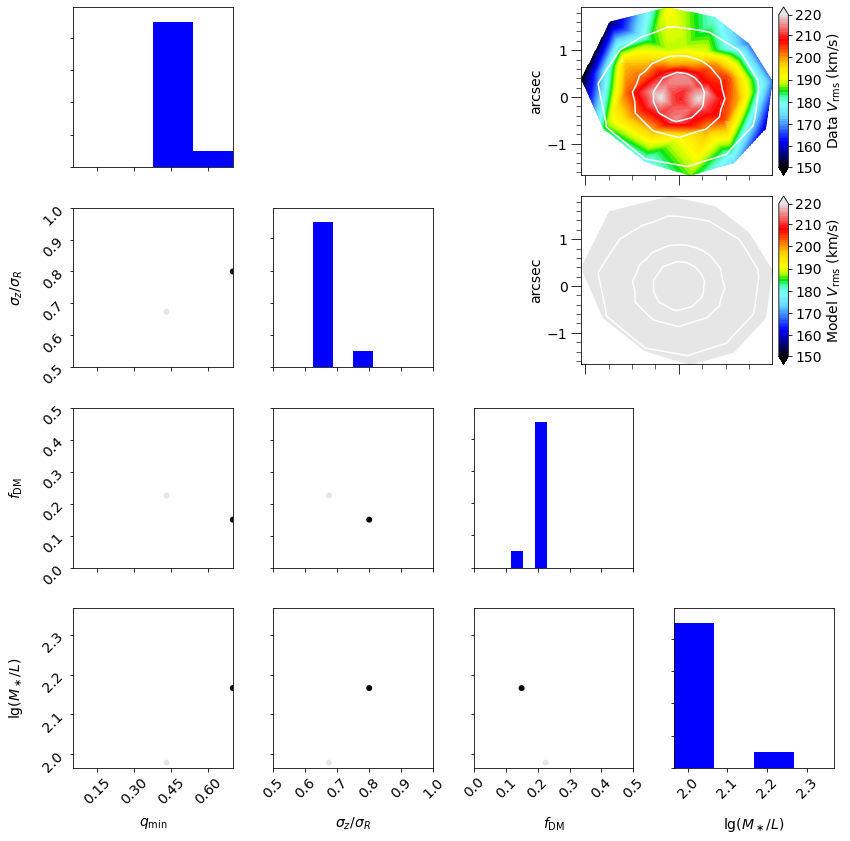

Dynamical mass estimate: 3.71e+12 +/- 3.89e+10
########################################################
We've been... JAMMED! On to the next?
########################################################
########################################################
Okay, all done. Thank you for using MiseryBot 9.1.3. We deprecated while you were away. Hope you data is not corrupted.


In [120]:
# set mass model, anisotropy, and alignment
models = ['power_law','nfw']
anis = ['const']
aligns = ['sph', 'cyl']

# set nstep
nstep=10

print('Thank you for choosing MiseryBot 9.3.2, where you will hate everything and probably quit after a short while.')
print('...')
print('...')
print('...')
print('Please hold...')
print('...')

print('')
print('Ah yes, the JAM routine. This one is fun.')
print('...')
print('...')
print('...')
print('But where to start?')
print('...')

print('########################################################')
print('########################################################')

for i, obj_name in enumerate(obj_names[:1]):
    
    print(f'Jamming object {obj_name}.')
    print('Brace for jamming.')
    print('########################################################') 
    
    for j, SN in enumerate(vorbin_SN_targets[1:]):
        
        print(f'Designated target is S/N {SN}.')
        
        for k, model in enumerate(models[1:]):
            for l, anisotropy in enumerate(anis):
                for m, align in enumerate(aligns):
                    
                    print(f'Commencing JAM routine with model {model}, anisotropy {anisotropy}, and alignment {align}... number of steps {nstep}')
                    print('JAMMING.')
                    print('########################################################') 

                    space_jam (obj_name, SN, model, anisotropy, align, nstep, p0=None, bounds=None)

                    print('########################################################') 
                    print("We've been... JAMMED! On to the next?")
                    print('########################################################') 
                    print('########################################################') 

print('Okay, all done. Thank you for using MiseryBot 9.1.3. We deprecated while you were away. Hope you data is not corrupted.')


In [123]:
import jampy
help(jampy)

Help on package jampy:

NAME
    jampy

PACKAGE CONTENTS
    examples (package)
    jam_axi_intr
    jam_axi_proj
    legacy (package)
    mge_half_light_isophote
    mge_radial_density
    mge_radial_mass
    mge_vcirc
    quad2d
    quadva

VERSION
    6.3.3

FILE
    /home/shawnknabel/.local/lib/python3.7/site-packages/jampy/__init__.py




In [125]:
import slacs_ani_mass_jam
help(slacs_ani_mass_jam)

Help on module slacs_ani_mass_jam:

NAME
    slacs_ani_mass_jam - 07/07/22 - Auxilliary functions for mass and anisotropy models, and running JAM with different combinations of those, as well as plotting devices.

CLASSES
    builtins.object
        jampy_details
    
    class jampy_details(builtins.object)
     |  jampy_details(surf_density, mge_sigma, q, kcwi_sigmapst, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff)
     |  
     |  # class to collect and save all the attributes I need for jampy
     |  
     |  Methods defined here:
     |  
     |  __init__(details, surf_density, mge_sigma, q, kcwi_sigmapst, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  ----------------------------------------------------------------------
     |  Data descriptors defined here:
     |  
     |  __dict__
     |      dictionary for instance variables (if defined)
     |  
   

# I want to save what is below.


Best-fitting parameters and 1sigma errors:
   $q_{\rm min}$ = 0.7466 +/- 0.087
   $\sigma_z/\sigma_R$ = 0.9804 +/- 0.037
   $f_{\rm DM}$ = 0.008297 +/- 0.023
   $\lg(M_\ast/L)$ = 1.796 +/- 0.013
Parameters saved to directory /home/shawn/data/CF_mosaics/SDSSJ0037-0942/model_2022_07_09-01_10_41_AM_nfw_const/


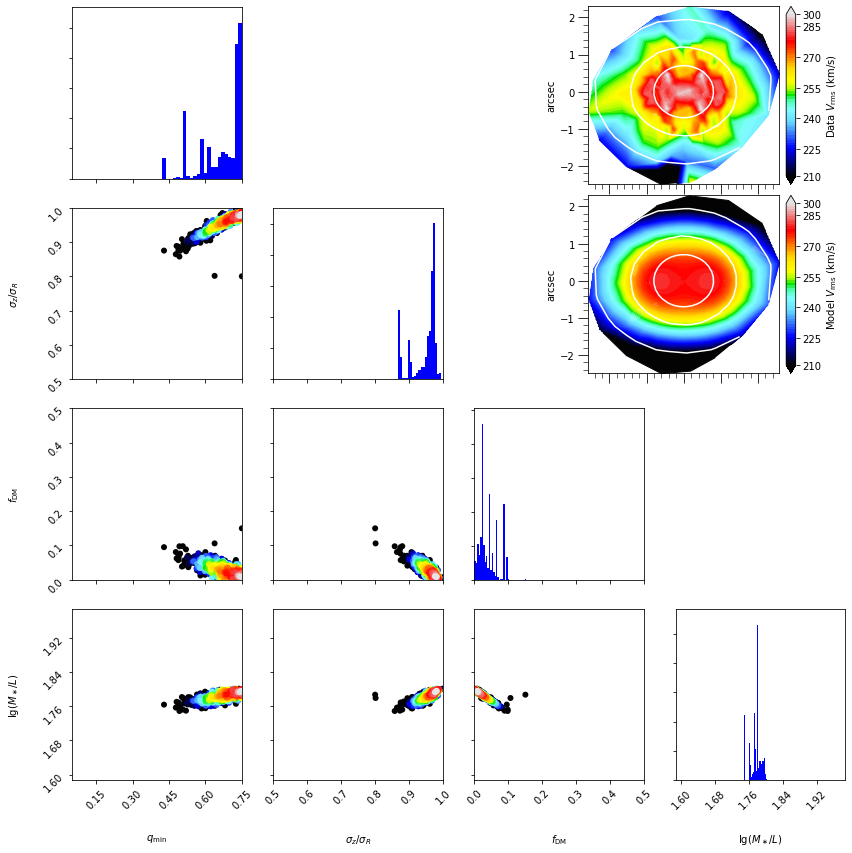

In [27]:
# plot the results, get rms_model and flux_model of best fit
surf_potential, rms_model, flux_model = summary_plot(xbin, ybin, goodbins, rms, pars, lnprob, 
                                                     labels, bounds, kwargs, obj_name, date_time,
                                                     model_dir, jam_lnprob_nfw_constbeta, save=True)

# save parameters from fit
save_fit_parameters(model_dir, obj_name, date_time, pars, lnprob, p0, sigpar, 
                    bounds, labels, surf_potential, rms_model, flux_model, kwargs)

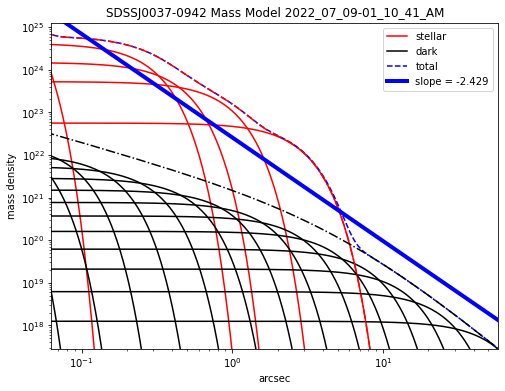

In [28]:
# plot the power law fit, save the figure
power_law_slope, intercept = get_power_law_slope(surf_potential, reff, surf_lum,
                                                obj_name, model_dir, 
                                                 date_time, save=True)

__________

# Let's do another model with generalized NFW profile.

## Use constant anisotropy and generalized NFW profile.


In [29]:
#############################################################
# JAM Parameters

##############################################################################

# assign only to the luminosity tracer
surf_lum = surf_density
sigma_lum = sigma
qobs_lum = q


'''
PSF from the optimization problem
'''
# kinematics sigmapsf
sigmapsf = kcwi_sigmapsf
normpsf = 1.
# kcwi pixel scale
pixsize = kcwi_scale

goodbins = None

# effective radius
reff = half_light_radius
rbreak = 5*reff

# kinematic bins
xbin = xbin_kin
ybin = ybin_kin

# data and errors
rms = Vrms_bin
erms = dVrms_bin

# set model to nfw
model = 'nfw_general'

##############################################################################

qmin = np.min(qobs_lum)

# Starting guess, e.g. from a previous least-squares fit
gamma0 = -1.6             # inner power law slope, typically for general NFW (according to Michele)
q0 = qmin               # Axial ratio of the flattest MGE Gaussian
ratio0 = 0.8            # Anisotropy ratio sigma_z/sigma_R
f_dm0 = 0.15           # Dark matter fraction inside a sphere of radius Re
lg_ml0 = np.log10(ml)  # M/L from the first fit... I sample the M/L logarithmically

# I adjusted the fitting range below after an initial fit which
# gave me an idea of some suitable ranges for the parameters
p0 = [gamma0, q0, ratio0, f_dm0, lg_ml0]
bounds = [[-3.0, 0.051, 0.5, 0, lg_ml0-0.2], [0.0, qmin, 1, 0.5, lg_ml0+0.2]]
labels = [r'$\gamma$',r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$f_{\rm DM}$", r"$\lg(M_\ast/L)$"]

goodbins = np.isfinite(xbin)  # Here I fit all bins

# These parameters are passed to JAM
kwargs = {'surf_lum': surf_lum, 'sigma_lum': sigma_lum, 'qobs_lum': qobs_lum,
          'distance': distance, 'xbin': xbin, 'ybin': ybin, 'sigmapsf': sigmapsf,
          'normpsf': normpsf, 'rms':rms, 'erms':erms, 'pixsize': pixsize,
          'goodbins': goodbins, 'plot': 0, 'model':model, 'reff':reff}


# Check starting parameters

/home/shawn/miniconda3/envs/astroconda/lib/python3.7/site-packages/jampy/jam_axi_proj.py:871: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.clf()


-1418.7066125381039

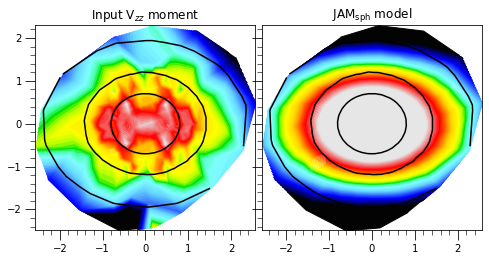

In [30]:
# nfw gen

jam_lnprob_nfwgen_constbeta(p0, surf_lum, sigma_lum, qobs_lum, distance,
                          xbin, ybin, sigmapsf, normpsf, goodbins,
                           rms, erms, pixsize, reff, plot=True, align='sph', model='nfw_general')

# Run the model...

In [31]:
#############################################################
# JAM Parameters

##############################################################################

# assign only to the luminosity tracer
surf_lum = surf_density
sigma_lum = sigma
qobs_lum = q


'''
PSF from the optimization problem
'''
# kinematics sigmapsf
sigmapsf = kcwi_sigmapsf
normpsf = 1.
# kcwi pixel scale
pixsize = kcwi_scale

goodbins = None

# effective radius
reff = half_light_radius
rbreak = 5*reff

# kinematic bins
xbin = xbin_kin
ybin = ybin_kin

# data and errors
rms = Vrms_bin
erms = dVrms_bin

# set mass model, anisotropy, and alignment
model = 'nfw_general'
anisotropy = 'const'
align = 'cyl'

##############################################################################

qmin = np.min(qobs_lum)

# Starting guess, e.g. from a previous least-squares fit
gamma0 = -1.6             # inner power law slope, typically for general NFW (according to Michele)
q0 = qmin               # Axial ratio of the flattest MGE Gaussian
ratio0 = 0.8            # Anisotropy ratio sigma_z/sigma_R
f_dm0 = 0.15           # Dark matter fraction inside a sphere of radius Re
lg_ml0 = np.log10(ml)  # M/L from the first fit... I sample the M/L logarithmically

# I adjusted the fitting range below after an initial fit which
# gave me an idea of some suitable ranges for the parameters
p0 = [gamma0, q0, ratio0, f_dm0, lg_ml0]
bounds = [[-3.0, 0.051, 0.5, 0, lg_ml0-0.2], [0.0, qmin, 1, 0.5, lg_ml0+0.2]]
labels = [r'$\gamma$',r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$f_{\rm DM}$", r"$\lg(M_\ast/L)$"]

goodbins = np.isfinite(xbin)  # Here I fit all bins

# These parameters are passed to JAM
kwargs = {'surf_lum': surf_lum, 'sigma_lum': sigma_lum, 'qobs_lum': qobs_lum,
          'distance': distance, 'xbin': xbin, 'ybin': ybin, 'sigmapsf': sigmapsf,
          'normpsf': normpsf, 'rms':rms, 'erms':erms, 'pixsize': pixsize,
          'goodbins': goodbins, 'plot': 0, 'reff':reff, 
          'model':model, 'anisotropy':anisotropy, 'align':align}

# This is a rather small number of steps for illustration.
# But the distribution has already qualitatively converged
nstep = 10000
sigpar = np.array([0.15, 0.15, 0.15, 0.05, 0.05])  # crude estimate of uncertainties

Started AdaMet please wait...
Progress is printed periodically


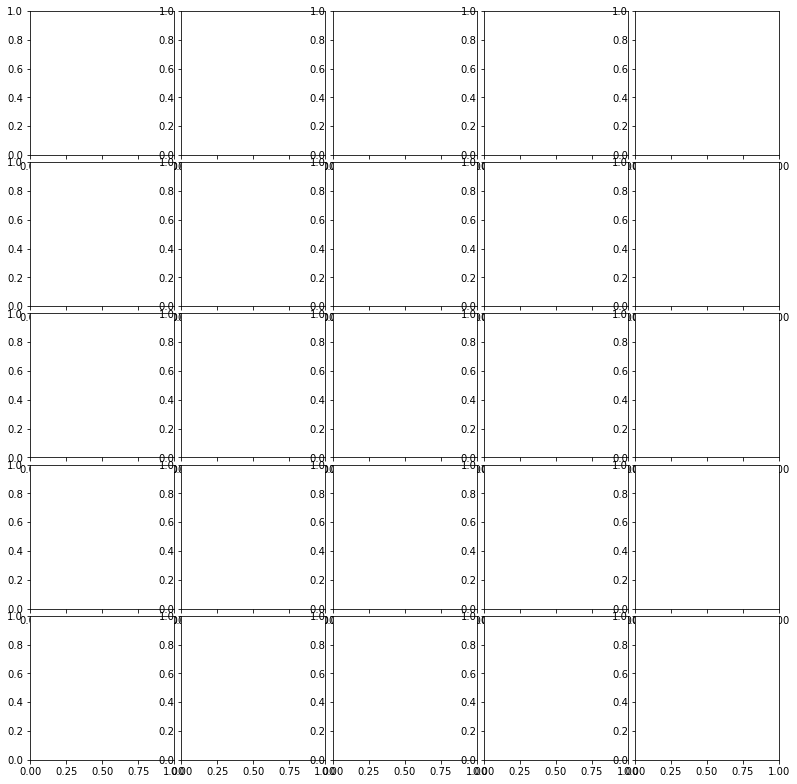

adamet: 5.0 % done; 1.4 % accepted
adamet: 10.0 % done; 0.9 % accepted
adamet: 15.0 % done; 0.7 % accepted
adamet: 20.0 % done; 0.7 % accepted
adamet: 25.0 % done; 0.6 % accepted
adamet: 30.0 % done; 0.5 % accepted
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `

ValueError: too many values to unpack (expected 4)

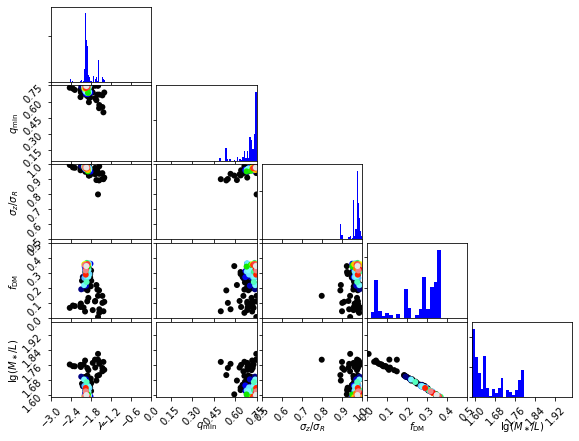

In [32]:
# Create directory
date_time = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
model_dir = f'{file_dir}model_{date_time}_{model}_{anisotropy}/'
os.mkdir(model_dir)

# Do the fit
print("Started AdaMet please wait...")
print("Progress is printed periodically")
jam_prob_func = jam_lnprob_nfwgen_constbeta

pars, lnprob = adamet(jam_prob_func, p0, sigpar, bounds, nstep, fignum=1,
                      kwargs=kwargs, nprint=nstep/20, labels=labels, seed=2)

# plot the results, get rms_model and flux_model of best fit
surf_potential, rms_model, flux_model = summary_plot(xbin, ybin, goodbins, rms, pars, lnprob, 
                                                     labels, bounds, kwargs, obj_name, date_time,
                                                     model_dir, jam_lnprob_nfwgen_constbeta, save=True)

# save parameters from fit
save_fit_parameters(model_dir, obj_name, date_time, pars, lnprob, p0, sigpar, 
                    bounds, labels, surf_potential, rms_model, flux_model, kwargs)


Best-fitting parameters and 1sigma errors:
   $\gamma$ = -1.945 +/- 0.18
   $q_{\rm min}$ = 0.7452 +/- 0.041
   $\sigma_z/\sigma_R$ = 0.9783 +/- 0.014
   $f_{\rm DM}$ = 0.3482 +/- 0.14
   $\lg(M_\ast/L)$ = 1.599 +/- 0.086
Parameters saved to directory /home/shawn/data/CF_mosaics/SDSSJ0037-0942/model_2022_07_09-01_41_06_AM_nfw_general_const/


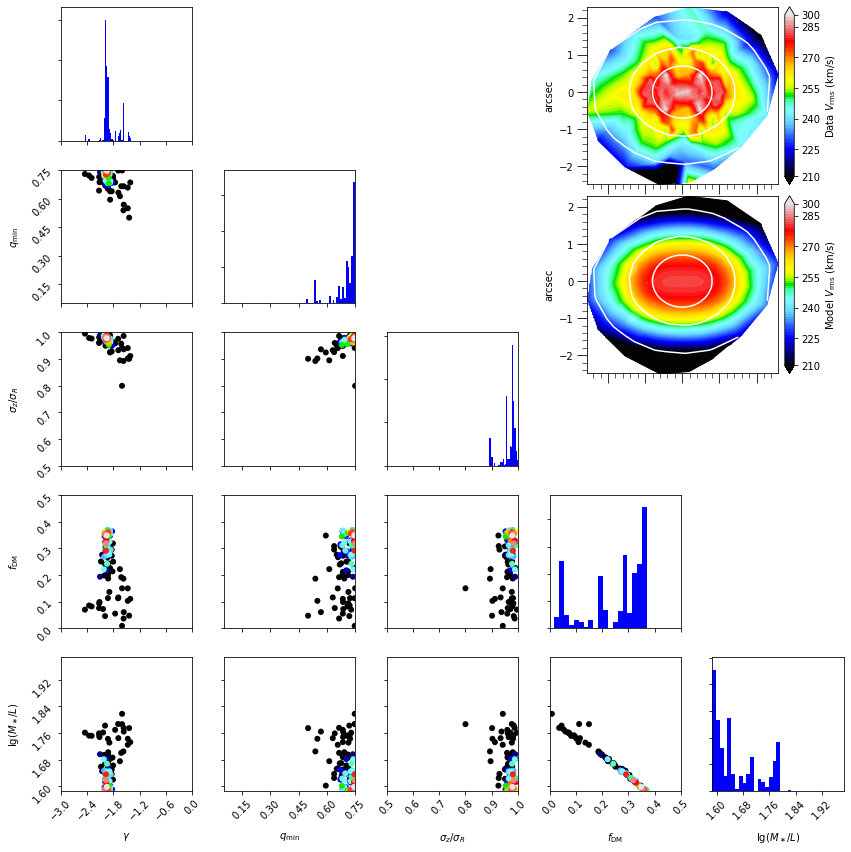

In [33]:
# plot the results, get rms_model and flux_model of best fit
surf_potential, rms_model, flux_model = summary_plot(xbin, ybin, goodbins, rms, pars, lnprob, 
                                                     labels, bounds, kwargs, obj_name, date_time,
                                                     model_dir, jam_lnprob_nfwgen_constbeta, save=True)

# save parameters from fit
save_fit_parameters(model_dir, obj_name, date_time, pars, lnprob, p0, sigpar, 
                    bounds, labels, surf_potential, rms_model, flux_model, kwargs)

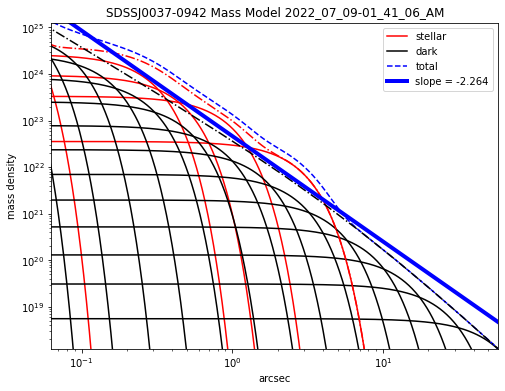

In [34]:
# plot the power law fit, save the figure
power_law_slope, intercept = get_power_law_slope(surf_potential, reff, surf_lum,
                                                obj_name, model_dir, 
                                                 date_time, save=True)

__________________
__________________

# BREAK
__________________
__________________